In [690]:
!pip install plotly --upgrade  --quiet
!pip install apafib --upgrade  --quiet

# De esta nos hacemos ricos
Las finanzas son un área de aplicación del aprendizaje automático y las redes neuronales. Estano es sencilla dados los múltiples factores que intervienen y lo difícil que es representarlos y estimarlos adecuadamente, pero a veces se pueden hacer estimaciones que dan una idea del comportamiento de los datos.
En este problema trabajaremos con datos reales del NASDAQ sobre la cotización de las acciones de cinco empresas tecnológicas (Google, Microsoft, Apple, Intel y AMD) durante cinco años.

Puedes obtener los datos mediante la función load_Google de la librería apafib. Esta retornará un dataframe que tiene tres columnas para cada acción, el valor final de la acción al final del día (P), el volumen de acciones que se intercambiaron (V) y la diferencia entre el mayor y el menor precio al que cotizaron en el día (GAP). En este problema intentaremos predecir la evolución
del precio de la acción de Google (GOOGLE-P).

Resuelve los siguientes apartados ilustrando los resultados de la manera que te parezca más adecuada.

In [764]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

torch.manual_seed(33)

# Si usamos usando CUDA (en mi caso usaré la cpu, si se quiere usar cuda deberiamos cambiar el formato de los datos a model.to('cuda') en lugar de model.to('cpu'))
if torch.cuda.is_available():
    torch.cuda.manual_seed(33)
    torch.cuda.manual_seed_all(33)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Apartado A

Haz un estudio de las características de los datos calculando sus estadísticas, la correlación entre los datos y representándolos de la manera que te parezca interesante. ¿Crees que puede ser posible predecir unas variables a partir de otras?

Divide los datos en conjunto de entrenamiento (los 1000 primeros días), otro de validación (100 días) y test (el resto). Estandariza los datos.

Para generar los datos para los modelos necesitaremos ventanas temporales de cierta longitud. Pandas permite generar una copia de una tabla de datos desplazada una serie de instantes temporales usando el método shift. Genera un conjuntos de datos con longitud de ventana 8 de manera que puedas predecir un día a partir de las variables de los siete anteriores Elimina todos los valores perdidos que ha generado esta transformación.

Para pasarle los datos a un modelo de torch hay que definir una clase del tipo Dataset, tienes una definida en el notebook del problema a la que hay que pasarle la matriz de datos y el vector con los valores a predecir. Esta clase se ha de pasar a un objeto Dataloader que se encarga de organizar el uso de los datos durante el entrenamiento, entre otras cosas de partir los datos en grupos (batch_size), puedes ver un ejemplo en el notebook.

In [913]:
from apafib import load_Google

raw_df = load_Google()
raw_df[:10]
raw_df[:-10]

,GOOGLE-P,GOOGLE-V,GOOGLE-GAP,MSFT-P,MSFT-V,MSFT-GAP,AAPL-P,AAPL-V,AAPL-GAP,INTEL-P,INTEL-V,INTEL-GAP,AMD-P,AMD-V,AMD-GAP
Date,,,,,,,,,,,,,,,
2017-08-21,45.3330,18846560,0.4800,72.15,17698800,0.7800,39.3025,105320280,0.6950,34.92,26479700,0.58,12.05,58786300,0.5600
2017-08-22,46.2345,23326400,0.7192,73.16,14333220,0.8900,39.9450,86259560,0.4950,34.65,26093400,0.57,12.17,38946780,0.2300
2017-08-23,46.3500,21771500,0.5285,72.72,13758650,0.6200,39.9950,77507760,0.3975,34.66,19775620,0.43,12.48,44193270,0.5850
2017-08-24,46.0640,25323820,0.7670,72.69,17097240,0.7900,39.8175,79128680,0.5475,34.71,14283180,0.34,12.50,37161680,0.3200
2017-08-25,45.7945,21055280,0.5027,72.82,12790300,0.8700,39.9650,100738400,0.3225,34.67,14714810,0.35,12.43,29650370,0.3200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,115.4800,22856200,2.4300,278.01,21539580,5.4400,161.5100,67829380,2.7000,36.96,52513450,1.64,96.78,96477500,4.4300
2022-08-02,115.9000,17911040,2.8200,274.82,22754180,5.5100,160.0100,59907030,2.7800,36.01,53929370,0.66,99.29,116734100,5.5550
2022-08-03,118.7800,25302820,3.2700,282.47,23518870,6.8900,166.1300,82507490,5.8400,36.52,59513860,1.33,98.09,131142000,5.1493


Como vemos, tenemos datos des de Agosto del 2017 hasta el agosto del 2022, 5 años, puede sorprender que solo tengamos 1259 instancias a primera vista, pero los mercados no abren ni el fin de semana ni los festivos, por eso el numero de instancias no equivale a 365*5.

In [914]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1259 entries, 2017-08-21 to 2022-08-19
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   GOOGLE-P    1259 non-null   float64
 1   GOOGLE-V    1259 non-null   int64  
 2   GOOGLE-GAP  1259 non-null   float64
 3   MSFT-P      1259 non-null   float64
 4   MSFT-V      1259 non-null   int64  
 5   MSFT-GAP    1259 non-null   float64
 6   AAPL-P      1259 non-null   float64
 7   AAPL-V      1259 non-null   int64  
 8   AAPL-GAP    1259 non-null   float64
 9   INTEL-P     1259 non-null   float64
 10  INTEL-V     1259 non-null   int64  
 11  INTEL-GAP   1259 non-null   float64
 12  AMD-P       1259 non-null   float64
 13  AMD-V       1259 non-null   int64  
 14  AMD-GAP     1259 non-null   float64
dtypes: float64(10), int64(5)
memory usage: 157.4+ KB


Vemos que no tenemos valores nulos, lo que siempre es de agradecer dado que nos olvidamos de tratar valores faltantes.

In [915]:
raw_df.describe()

,GOOGLE-P,GOOGLE-V,GOOGLE-GAP,MSFT-P,MSFT-V,MSFT-GAP,AAPL-P,AAPL-V,AAPL-GAP,INTEL-P,INTEL-V,INTEL-GAP,AMD-P,AMD-V,AMD-GAP
count,1259.000000,1.259000e+03,1259.000000,1259.000000,1.259000e+03,1259.000000,1259.000000,1.259000e+03,1259.000000,1259.000000,1.259000e+03,1259.000000,1259.000000,1.259000e+03,1259.000000
mean,82.353323,3.091715e+07,1.740178,181.820564,2.953929e+07,3.812815,90.350676,1.184749e+08,2.068242,50.894599,2.900960e+07,1.216749,56.722025,6.915626e+07,2.409231
std,32.320527,1.347789e+07,1.209965,78.621047,1.299424e+07,2.912805,46.269086,5.504025e+07,1.694044,6.684044,1.464157e+07,0.739385,38.704107,3.595598e+07,2.177979
min,45.333000,6.935060e+06,0.238000,72.150000,7.425603e+06,0.340000,35.547500,4.099995e+07,0.213500,34.520000,6.313179e+06,0.210000,9.530000,1.103576e+07,0.120000
25%,56.103500,2.256946e+07,0.871300,108.150000,2.125149e+07,1.660000,47.482500,8.193916e+07,0.776250,46.720000,1.978076e+07,0.760000,21.665000,4.331598e+07,0.820000
50%,67.365000,2.773012e+07,1.371000,163.490000,2.629290e+07,3.060000,71.932500,1.042700e+08,1.502500,50.590000,2.584577e+07,1.026500,48.210000,5.859729e+07,1.720000
75%,112.941500,3.531136e+07,2.218750,252.485000,3.374066e+07,5.141250,133.640000,1.382814e+08,2.925000,55.380000,3.400318e+07,1.450000,87.095000,8.561404e+07,3.295000
max,150.709000,1.238938e+08,9.215500,343.110000,1.109450e+08,23.640000,182.010000,4.268848e+08,12.810000,68.470000,1.822699e+08,8.620000,161.910000,3.238445e+08,15.900000


Por otra parte nos damos cuenta tambien de que la fecha se encuentra en el indice de los datos, importante saberlo para despues tratar con ella

In [693]:
print(raw_df.index)

Index(['2017-08-21', '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
       '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31', '2017-09-01',
       ...
       '2022-08-08', '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12',
       '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18', '2022-08-19'],
      dtype='object', name='Date', length=1259)


### Análisis y visualización de variables

Procedemos a ver que distribucion siguen las 3 variables para cada empresa

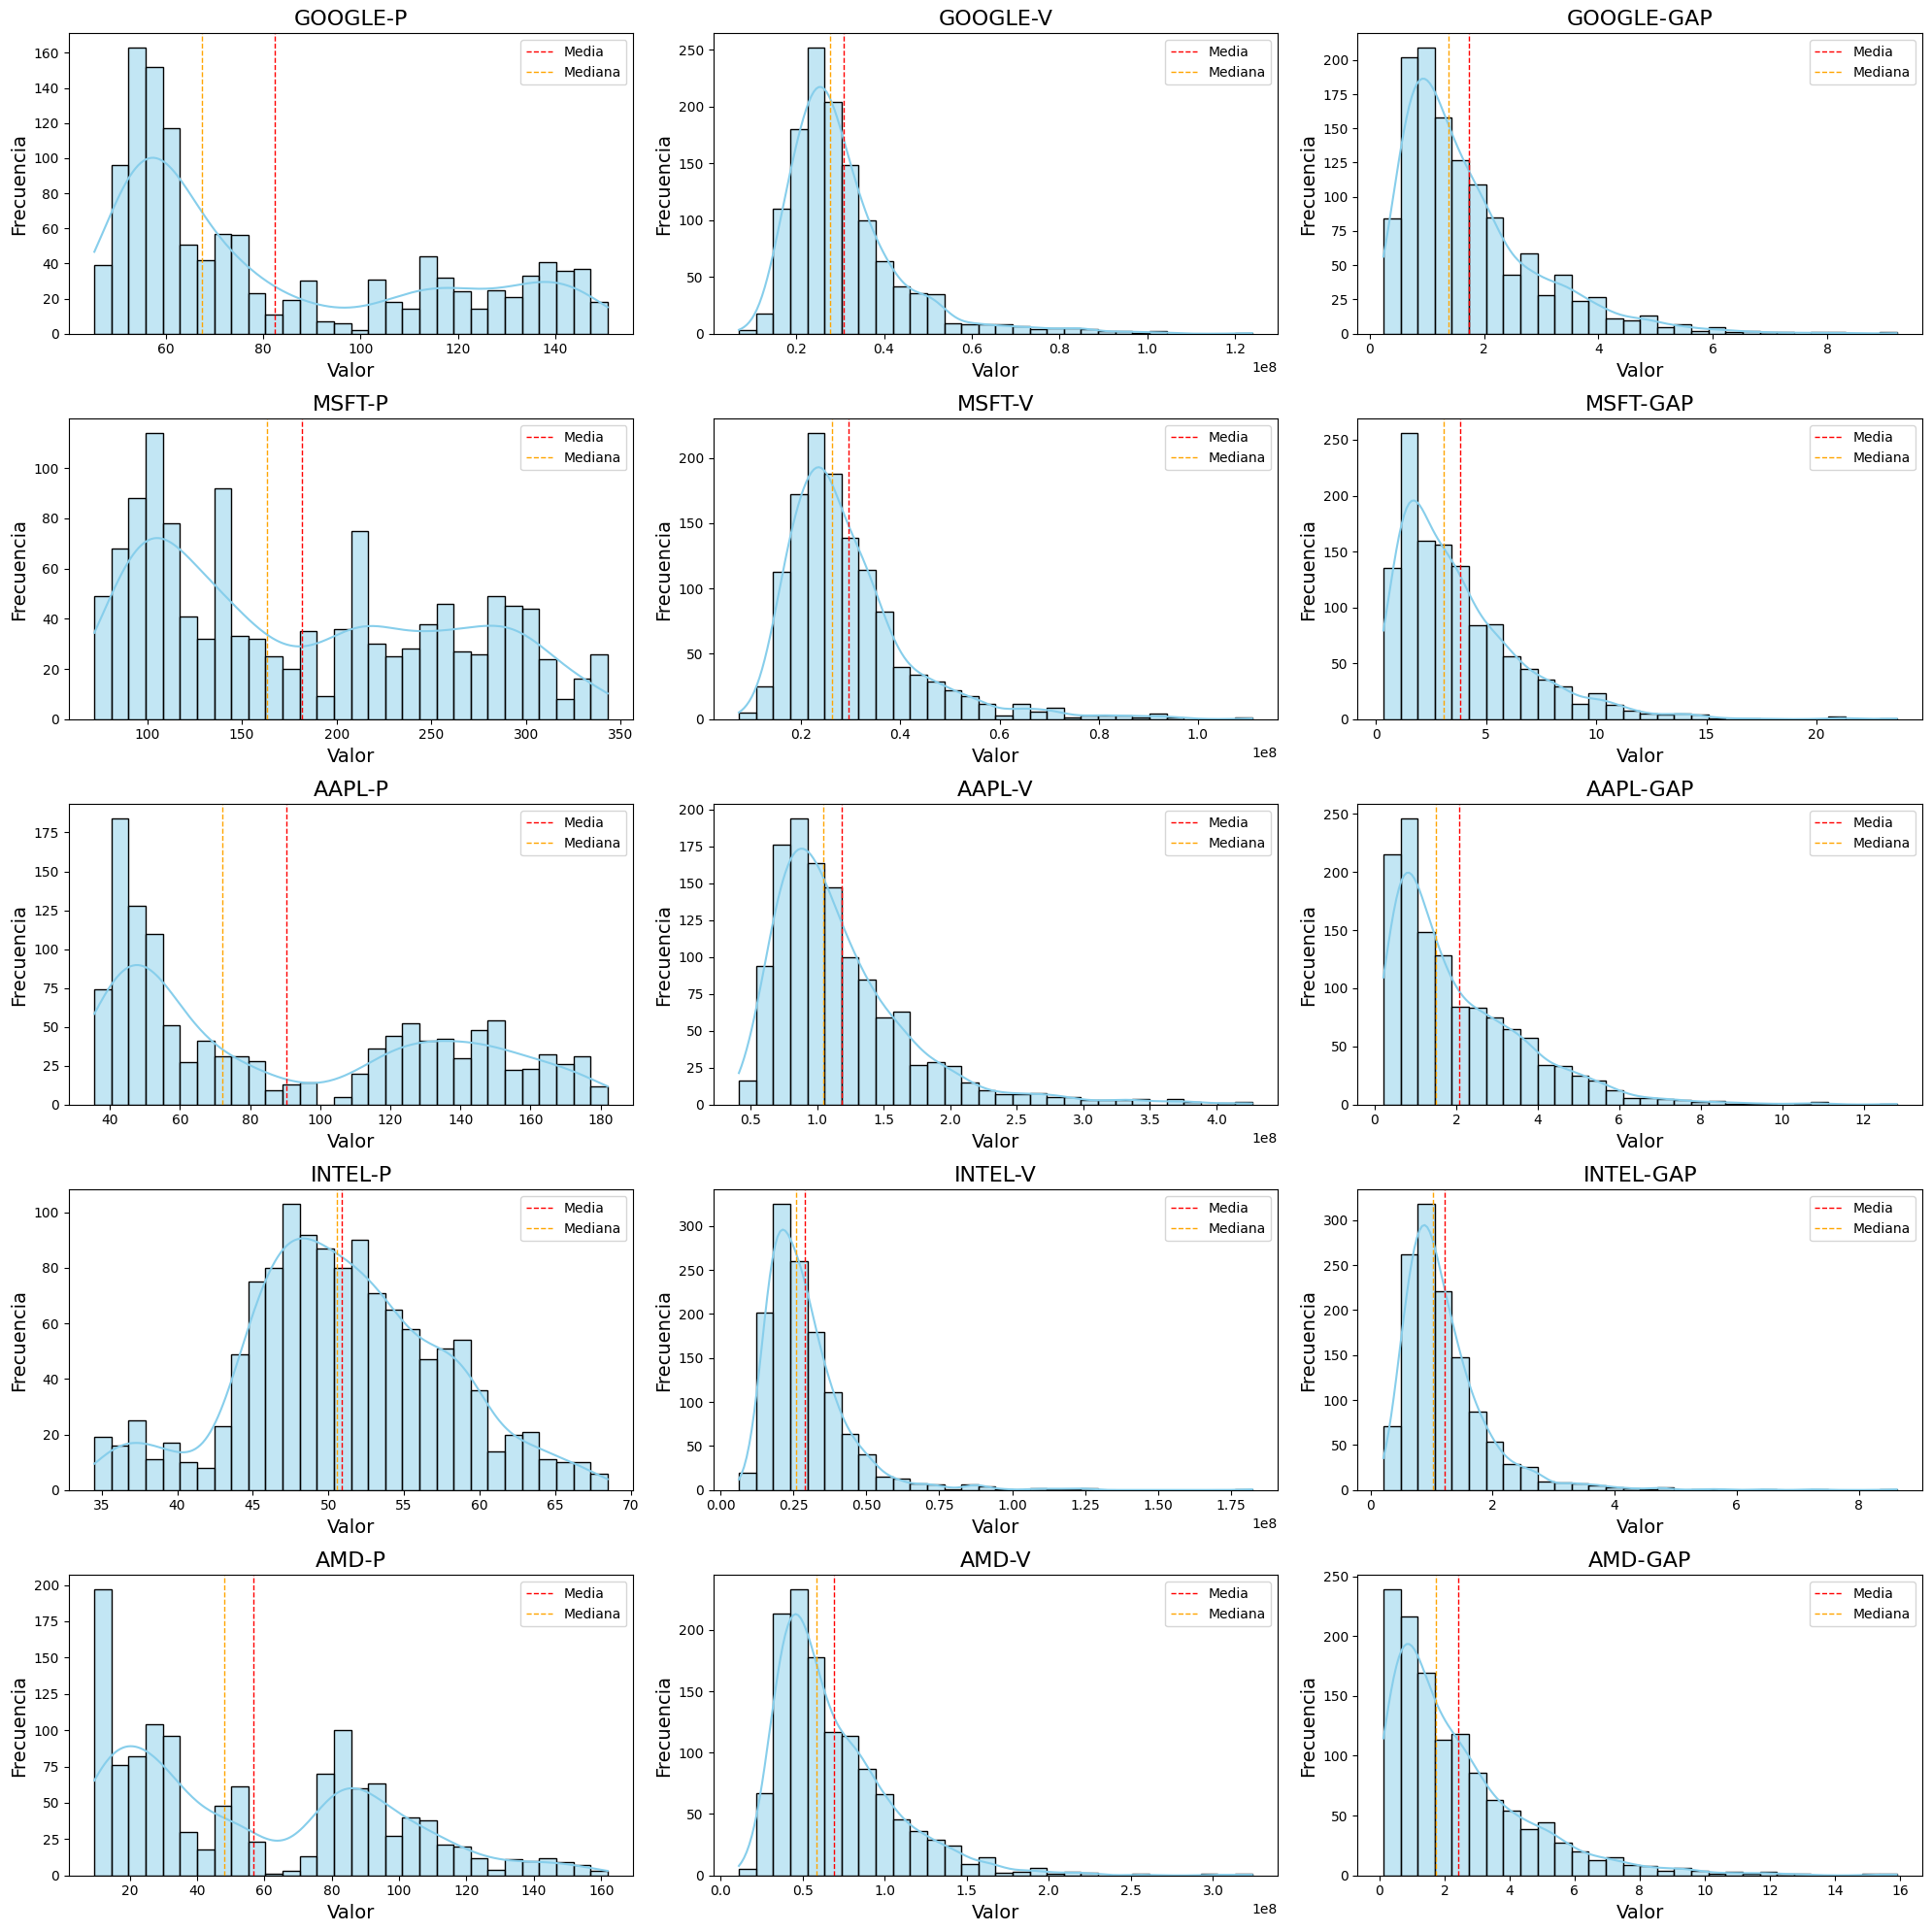

In [916]:
fig, axes = plt.subplots(5, 3, figsize=(20, 20))

for i, c in enumerate(raw_df.columns):
    ax = axes.flatten()[i]
    sns.histplot(data=raw_df, x=c, ax=ax, bins=30, kde=True, color='skyblue')
    ax.set_title(c, fontsize=16)
    ax.set_xlabel('Valor', fontsize=14)
    ax.set_ylabel('Frecuencia', fontsize=14)

    mean = raw_df[c].mean()
    median = raw_df[c].median()
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Media')
    ax.axvline(median, color='orange', linestyle='dashed', linewidth=1, label='Mediana')
    ax.legend()

plt.tight_layout();
plt.show();

Tras mostrar las tres variables para cada empresa vemos como se comportan de forma muy similar.

Observamos que:
- Como era de esperar la variable de precio se comporta bastante distinta a las demas. Vemos bastante claramente como en todas las empresas menos Intel hay dos distribuciones gaussianas sobrepuestas, una con una frecuencia mas alta que la otra. Esto nos hace pensar que en los datos, las acciones tuvieron un canvio en su cotización en el período temporal que comprenden los datos, incluso podemos decir que en los datos las acciones estuvieron mas tiempo en un precio bajo que en un precio alto.

- los volumenes de las acciones se concentran todos en la parte izquierda del eje X y siguen una distribución un poco gaussiana a pesar de que la cola derecha es mucho mas ancha que la izquierda, lo que cuadra con la realidad dado que la mayoria de dias del año, una acción teiene un volumen de compras y de ventas parecido, excepto esos dias que por factores como publicación de resultados de la empresa, noticias geopolíticas, nuevas inversiones... los accionistas estan mucho mas activas con esa empresa y por lo tanto hay mas ventas y compras.

- por otra parte la variable GAP parece comportarse de forma bastante parecida al volumen, pese a que observamos esa cola derecha mucho mas pronunciada y por lo tanto a parte de que la media y la mediana no estan tan centradas en el pico de la campana, estan mas desplazadas hacia la cola derecha y a su vez mas seperadas entre si.

### Variable vs Fecha

A continuación procedemos a mostrar los gráficos para ver como evolucionan tanto el precio de cotzación como el GAP como el Volumen temporalmente

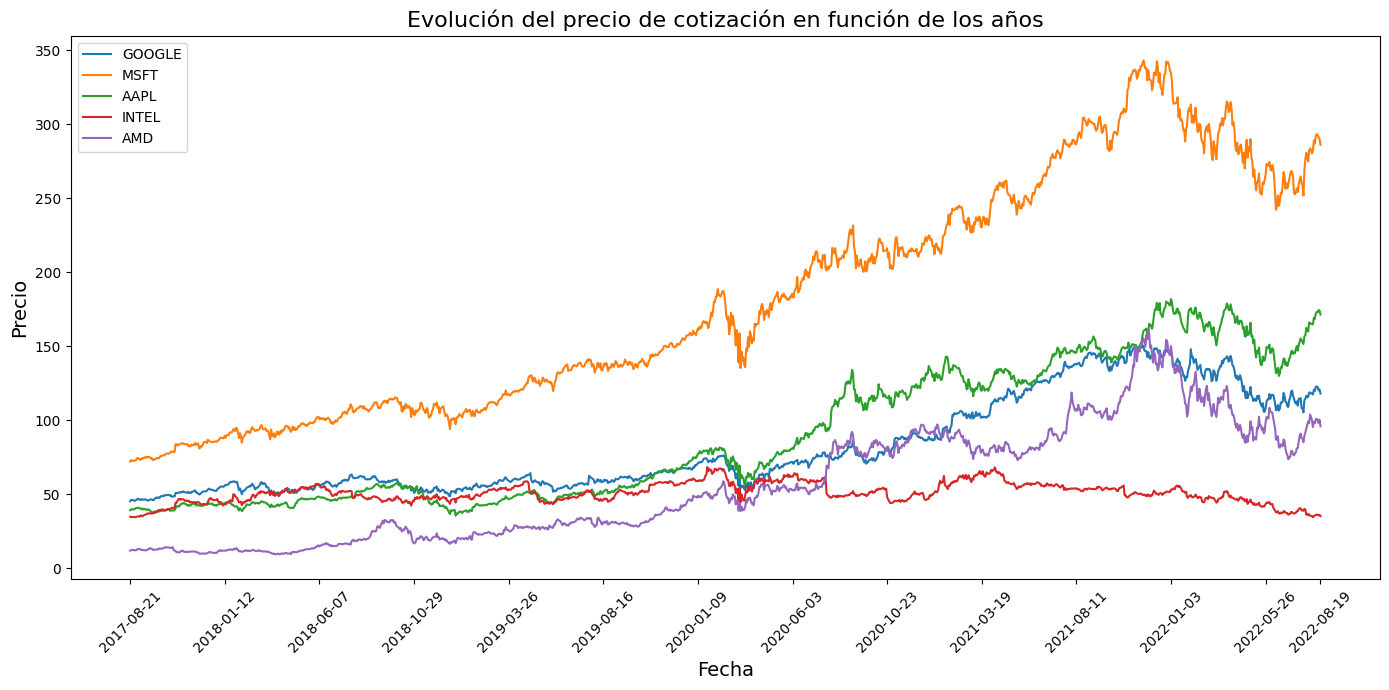

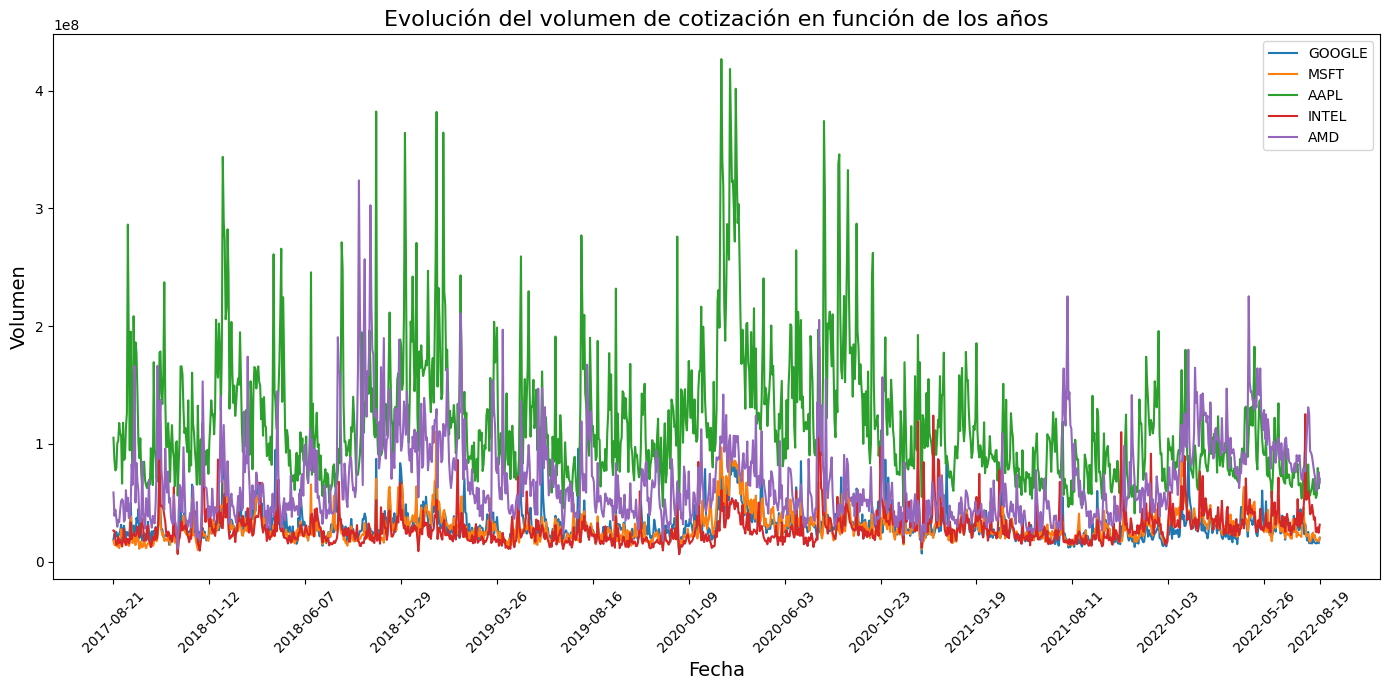

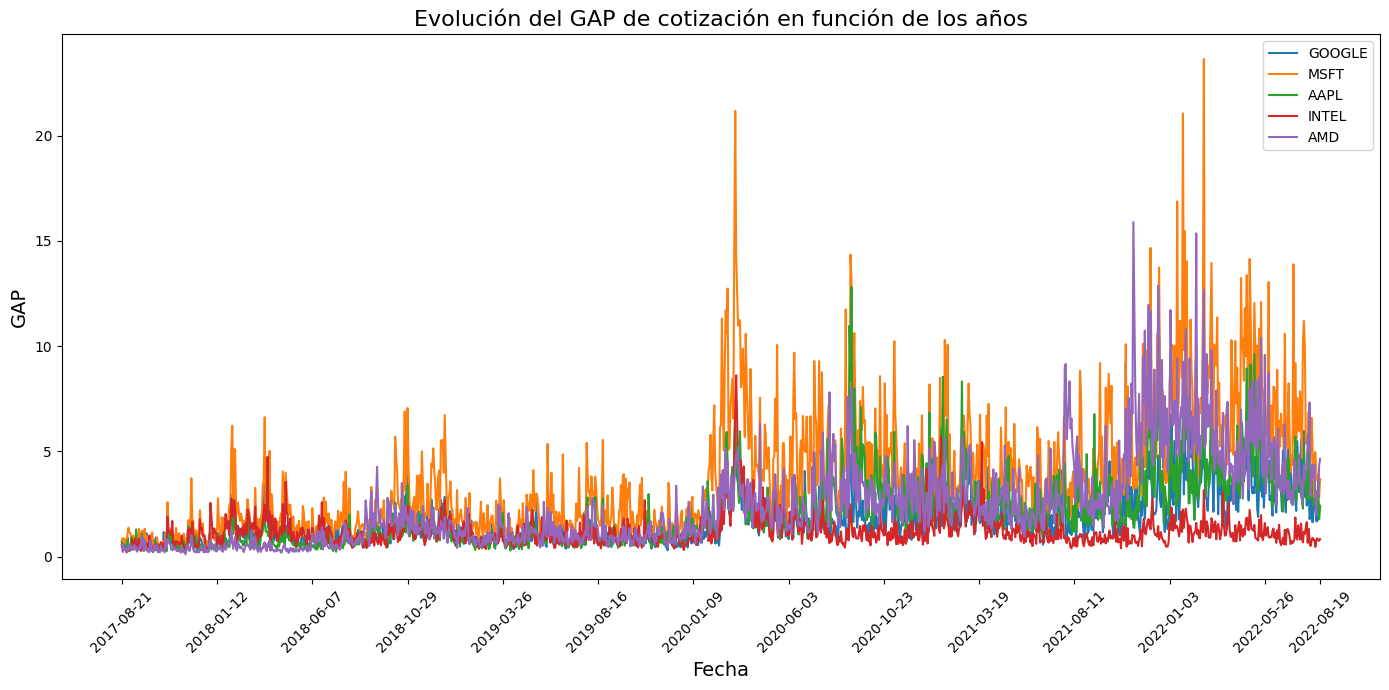

In [917]:
def plot_evolution(df, variable_suffix, title, ylabel):
    dates = df.index
    fig, ax = plt.subplots(figsize=(14, 7))

    for company in ['GOOGLE', 'MSFT', 'AAPL', 'INTEL', 'AMD']:
        ax.plot(dates, df[f'{company}-{variable_suffix}'], label=company)

    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Fecha', fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.legend()

    # Mostramos una etiqueta cada 100 valores
    ax.set_xticks(list(dates[::100]) + [dates[-1]])
    ax.set_xticklabels(list(dates[::100]) + [dates[-1]], rotation=45)

    plt.tight_layout()
    plt.show()

# Gráfico de la evolución del precio de cotización
plot_evolution(raw_df, 'P', 'Evolución del precio de cotización en función de los años', 'Precio')

# Gráfico de la evolución del volumen
plot_evolution(raw_df, 'V', 'Evolución del volumen de cotización en función de los años', 'Volumen')

# Gráfico de la evolución del GAP
plot_evolution(raw_df, 'GAP', 'Evolución del GAP de cotización en función de los años', 'GAP')

#### Conclusiones de las observaciones
Si analizamos el período de nuestros datos para ver que factores globales, sectoriales (dado que las 5 son del sector tecnológico) o incluso individuales, podemos hacer un análisis con mucho mas peso de los 3 gráficos obtenidos.

Vemos como el primer periodo comprendido del 2017 a principios del 2020, fue un periodo de crecimiento general en el sector, sobretodo en AMD y MSFT.

`Acontecimientos globales:`
- A partir del 2020, como todos sabemos, llega la pandemia mundial del COVID, es a partir de allí, en el mes de marzo, cuando la cosa empieza a tomar unas dimensiones de mucho mayor calibre y es cuando empezamos a ver que los gobiernos empiezan a obligar a las empresas a cerrar negocios y a activar los estados de emergencia, vemos como en menos de un mes las acciones caen entorno un 30 y un 40%, que si lo vemos en perspectiva no parece mucho, pero en ese momento los accionistas sufrieron unas semanas de auténtica crisis.

- Sin embargo, la bolsa se recupero bastante rápido de esta crisis sobretodo en este sector ya que el mundo estaba (y esta) en un proceso de digitalización muy elevado, hubieron sectores que tardaron mucho mas, por tanto vemos que hasta principios del 2022 todas las acciones menos Intel(por un motivo sectorial que comentaremos posteriormente), no pararon de subir.

- Llegamos al 2022 y observamos un cambio de tendencia significativo, que se esdeviene debido a que nos encontrabamos en un proceso de alta inflación y los bancos centrales deciden empezar a aumentar los tipos de interes para frenar esta inlfación (dado que era de demanda). Esto afecta directamente a las empresas sobretodo a aquellas que funcionan con una deuda muy elevada y con unos gastos en capital e I+D muy elevados. Las empresas tecnológicas son unas de las que se vieron mas afectadas, ya que ademas de llevar un proceso de crecimiento muy elevado con lo que se encontraban un poco sobrevaloradas, se le añade el problema de obtener financiamiento barato para todos los gastos comentados previamente y el problmea de que la gente empieza a tener que reducir gastos dado que les empiezan a aumentar los costes como hipotecas, préstamos...

`Acontecimientos sectoriales:`
- Durante estos últimos años ha habido una aceleración en la digitalización y sobretodo en la infraestructura cloud, eso a conllevado que empresas de software y servicios tecnológicos como Microsoft y Google crecieran debido a la demanda de servicios de computación en la nube, herramientas de colaboración y servicios digitales.

- Como hemos comentado previamente, INTEL fue la única que empezo a desinflarse y nunca se llego a recuperar a precios precovid, esto es fundamentalmente a la gran competencia en el mercado de chips (AMD/NVIDIA... vs. Intel) AMD, NVDIDIA y estas empresas comenzaron a ganar cuota de mercado a Intel gracias a sus procesadores más eficientes y competitivos. Intel sufrió retrasos en su tecnología de fabricación de chips lo que afectó su reputación, a sus beneficios y por ende a su cotización.


`Acontecimientos individuales:`
- Como hemos comentado Google y Microsoft, empezaron con el negocio del servicio cloud que resultó, resulta y resultará un éxito con productos como Google Cloud y Azure.
- Microsoft aumento su gama de servicios con productos como Teams y la adquisición de LinkedIn.
- Apple como todos sabemos, no ha parado de lanzar nuevos iPhones y servicios compementarios.
- INTEL no ha parado de tener retrasos en su producción de chips que han conllevado a una pérdida de representación en la cuota de mercado de los chips.
- AMD ha tenido un éxito muy rotundo con sus procesadores Ryzen y EPYC rompiendo completamente contra el polinomio de INTEL y por otra parte el incremento de la demanda de las GPUs tambien ha favorecido con creces a AMD.

Viendo los tres gràficos vemos como momementos de cambios globales todas las variables tienen una correlación muy alta, viendo como la variable de GAP y Precio aun estan mas correlacionadas.

#### Matriz de Correlaciones

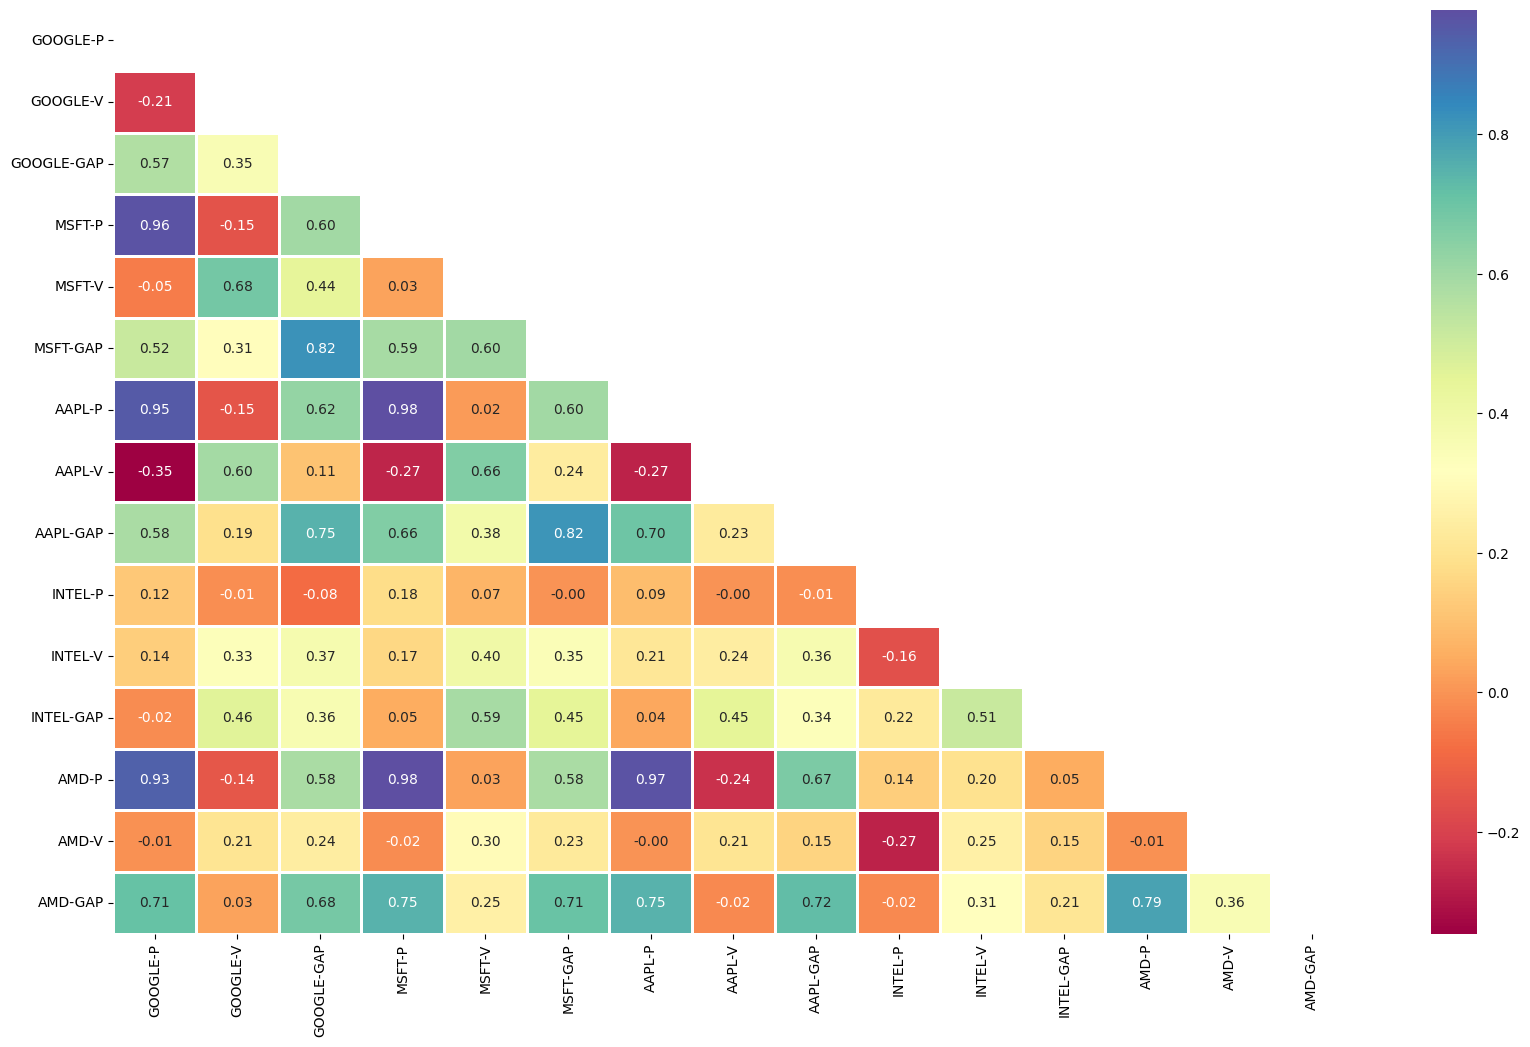

In [918]:
plt.figure(figsize=(20,12))
corr=raw_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap= 'Spectral', linewidths=1, annot=True, fmt = ".2f")
plt.show();

Como hemos visto en los gráficos anteriores, los precios de las acciones excepto el de INTEL, estan muy correlacionados entre ellos por otra parte el GAP tambien esta altamente correlacioando entre las variables aunque con un peso un poco menor.
Y por otra parte el volumen vemos que suele estar un poco inversamente correlacionado con el precio de la acción.

Por último si comparamos la que sera nuestra target variable (GOOGLE-P) con las demas, vemos como con las AMD, MSFT y APPLE esta correlacionada en cunato a precio con mas de un 93%, por otra parte esta un 50% correlacionada con las variables GAP de estas tres variables y con INTEL no esta nada correlacionada practicamente y finalmente si miramos los volúmenes, parece como su propio volumen como el de apple, nos pueden aportar cierta importancia ya que afectan negativamente con un peso mas pequeño que -0.2.

Una vez hecho en análisis previo, vemos como podria indicarnos que las variables de precio de las demas empresas nos podria ser posible predecir unas variables a partir de otras, pero como bien es sabido en el tema de predicción de valores en los mercados es muy difícil encontrar un modelo con alta precisión así que no nos podemos hacer grandes ilusiones.

#### Generación de ventanas

Procedemos a dividir los datos como se nos especifica en el enunciado, crearemos 106 ((3*5*7) + 1) columnas que equivalen a:
- 3 tipos de variables (V, P, GAP)
- 5 acciones (G, AMD, INT, MSFT, APPL)
- 7 dias 
- GOOGLE-P el octavo día

In [980]:
# Crear ventanas temporales de longitud 7 días
window_size = 7
variables = raw_df.columns

# Crear un nuevo DataFrame para almacenar las ventanas
windowed_df = pd.DataFrame()

# Generar las ventanas temporales
for i in range(window_size):
    shifted_df = raw_df.shift(i+1)
    shifted_df.columns = [f'{col}_t-{6-i}' for col in variables]
    windowed_df = pd.concat([windowed_df, shifted_df], axis=1)

# Agregar la variable objetivo (GOOGLE-P del día 8)
windowed_df['GOOGLE-P_t7'] = raw_df['GOOGLE-P']

# Eliminar los valores perdidos generados por la transformación
windowed_df.dropna(inplace=True)

print(windowed_df[['GOOGLE-P_t-0', 'GOOGLE-P_t-1', 'GOOGLE-P_t-2', 'GOOGLE-P_t-3', 'GOOGLE-P_t-4', 'GOOGLE-P_t-5', 'GOOGLE-P_t-6', 'GOOGLE-P_t7']].head(10))

            GOOGLE-P_t-0  GOOGLE-P_t-1  GOOGLE-P_t-2  GOOGLE-P_t-3  \
Date                                                                 
2017-08-30       45.3330       46.2345       46.3500       46.0640   
2017-08-31       46.2345       46.3500       46.0640       45.7945   
2017-09-01       46.3500       46.0640       45.7945       45.6905   
2017-09-05       46.0640       45.7945       45.6905       46.0645   
2017-09-06       45.7945       45.6905       46.0645       46.4785   
2017-09-07       45.6905       46.0645       46.4785       46.9665   
2017-09-08       46.0645       46.4785       46.9665       46.8670   
2017-09-11       46.4785       46.9665       46.8670       46.4225   
2017-09-12       46.9665       46.8670       46.4225       46.3905   
2017-09-13       46.8670       46.4225       46.3905       46.7975   

            GOOGLE-P_t-4  GOOGLE-P_t-5  GOOGLE-P_t-6  GOOGLE-P_t7  
Date                                                               
2017-08-30       45.794

#### Division de los conjuntos

Procedemos a dividir los datos en formato ventana en entrenamiento, validación y test.

In [981]:
X_train = windowed_df.drop(columns=['GOOGLE-P_t7'])[:1000]
X_val = windowed_df.drop(columns=['GOOGLE-P_t7'])[1000:1100]
X_test = windowed_df.drop(columns=['GOOGLE-P_t7'])[1100:]

y_train = windowed_df['GOOGLE-P_t7'][:1000]
y_val = windowed_df['GOOGLE-P_t7'][1000:1100]
y_test = windowed_df['GOOGLE-P_t7'][1100:]


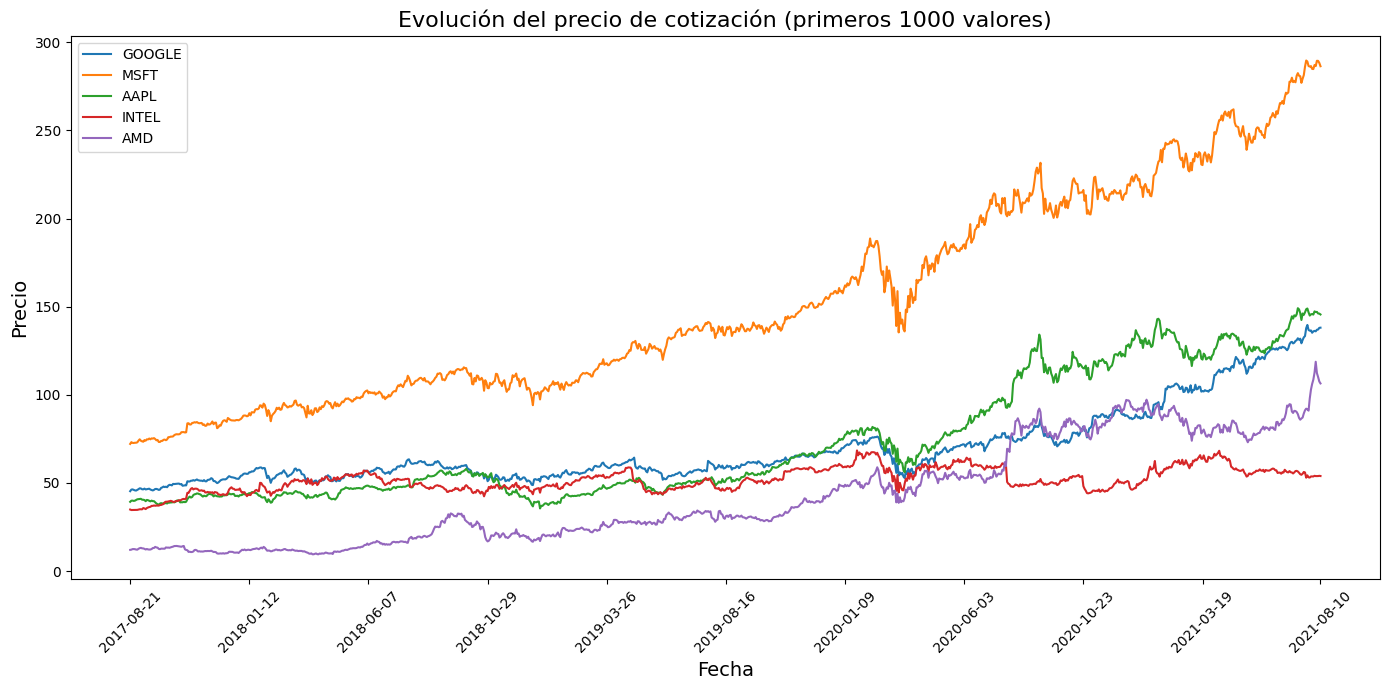

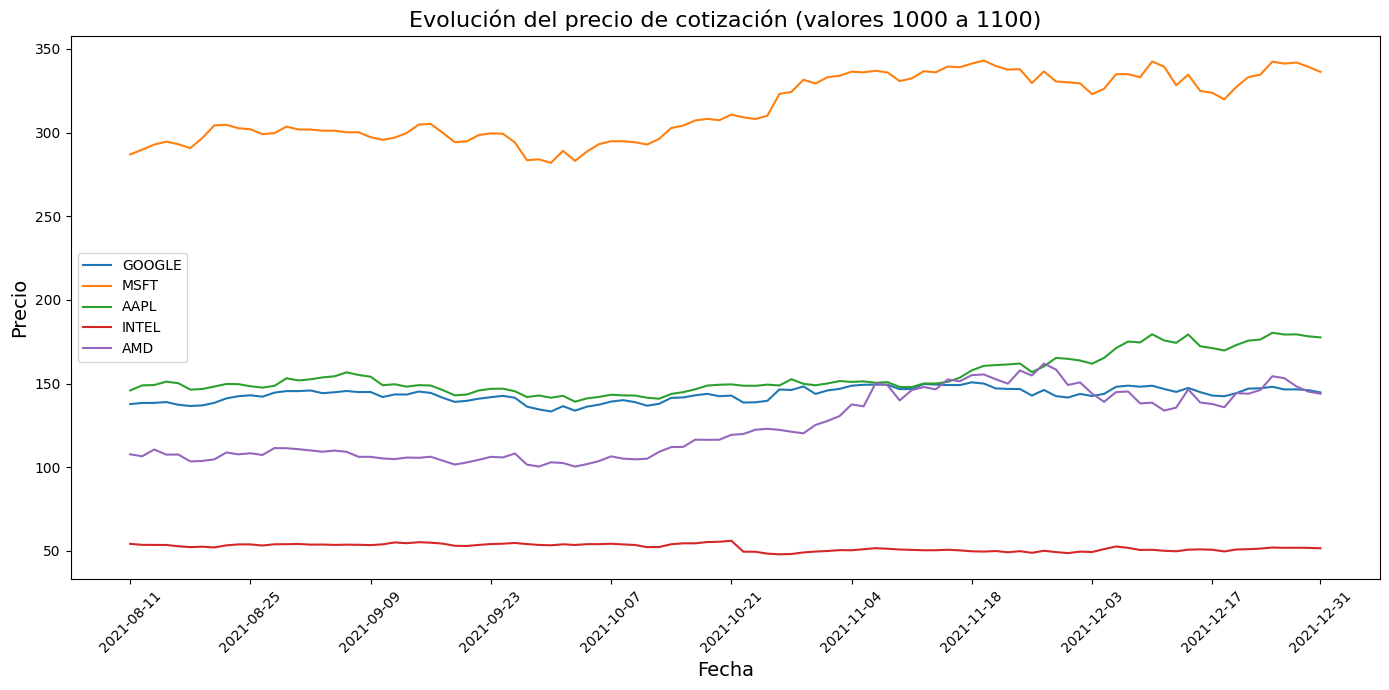

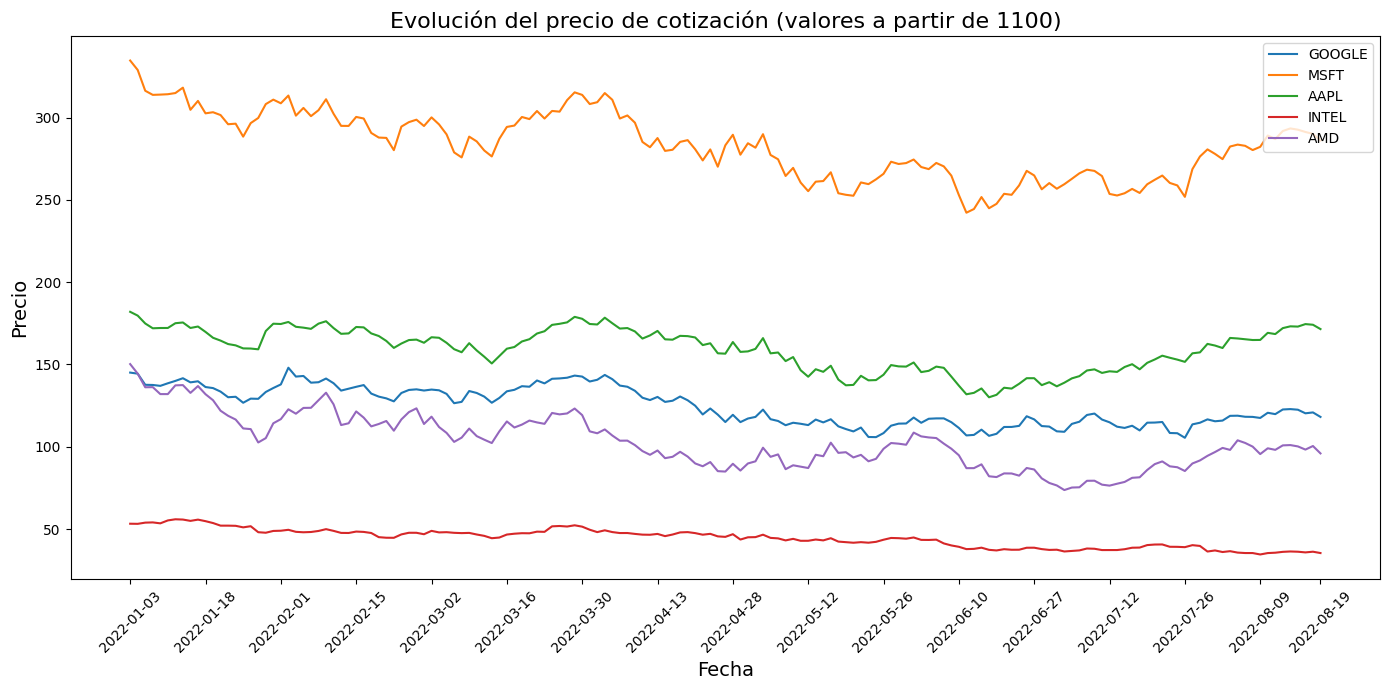

In [920]:
def plot_evolution(df, variable_suffix, title, ylabel, start, end, step):
    dates = df.index[start:end]
    fig, ax = plt.subplots(figsize=(14, 7))

    for company in ['GOOGLE', 'MSFT', 'AAPL', 'INTEL', 'AMD']:
        ax.plot(dates, df[f'{company}-{variable_suffix}'][start:end], label=company)

    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Fecha', fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.legend()

    # Mostramos una etiqueta cada 'step' valores
    ax.set_xticks(list(dates[::step]) + [dates[-1]])
    ax.set_xticklabels(list(dates[::step]) + [dates[-1]], rotation=45)

    plt.tight_layout()
    plt.show()

plot_evolution(raw_df, 'P', 'Evolución del precio de cotización (primeros 1000 valores)', 'Precio', 0, 1000, 100)

plot_evolution(raw_df, 'P', 'Evolución del precio de cotización (valores 1000 a 1100)', 'Precio', 1000, 1100, 10)

plot_evolution(raw_df, 'P', 'Evolución del precio de cotización (valores a partir de 1100)', 'Precio', 1100, len(raw_df), 10)

Mostramos como se comportan las variables en los intervalos de tiempo establecidos para tener una idea de como debería comportarse el modelo de aprendizaje y ver si realmente seria capaz de predecir los datos del ultimo intervalo a partir de los datos del primero y del segundo

#### Estandarización de los datos
Para estandarizar los datos utilizaremos el escalado MinMax dado que el hecho de que el volumen, el precio de cotizacion o el gap sea negativo no tiene mucho sentido.
Procederemos tambien a escalar la variable objetivo.

In [982]:
from sklearn.preprocessing import MinMaxScaler

# Estandarizar los datos
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Convertir en arrays de 1D para evitar errores en la futura clase NASDAQ (unsqueeze ya añade una dimension)
y_train_scaled = y_train_scaled.flatten()
y_val_scaled = y_val_scaled.flatten()
y_test_scaled = y_test_scaled.flatten()

#### Conversion a DataLoader

Procedemos a convertir los datos en formato DataLoader para poder trabajar en Torch correctamente

In [983]:
class NASDAQ(Dataset):
    def __init__(self, data, pred):
        self.data = torch.Tensor(data).float()
        self.pred = torch.Tensor(pred).float().unsqueeze(1)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.pred[index]

        return x, y

    def __len__(self):
        return len(self.data)

# Crear los objetos Dataset
train_dataset = NASDAQ(X_train_scaled, y_train_scaled)
val_dataset = NASDAQ(X_val_scaled, y_val_scaled)
test_dataset = NASDAQ(X_test_scaled, y_test_scaled)

# Crear los objetos DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Apartado B
Tenemos un problema de regresión, podemos usar un MLP que tenga una salida lineal para hacer la predicción con varias capas ocultas y ajustarlo usando mínimos cuadráticos (mean squared error). En el código del notebook tenéis una función que permite generar modelos MLP variando el número de capas y la función de activación. La re se define como una clase python donde en el método __init__ definimos los elementos de la red y en el forward como se hace la propagación hacia adelante en la red (la propagación hacia atrás se calcula automáticamente).

Para entrenar los modelos usaremos la función train_loop que tienes en el notebook. Esta función recibe el modelo, el optimizador a usar, los datos de entrenamiento y validación,la paciencia para la terminación temprana y el número de iteraciones que hará el entrenamiento. Para el optimizador usaremos adam, puedes ver en el notebook como generar el objeto del optimizador.
Entrena diferentes redes de 1 y 2 capas con diferentes tamaños usando como función de activación Sigmoid y ReLU. Para los tamaños de las dos capas puedes elegir el tamaño de la primera capa oculta y después reducirlo a la mitad para la segunda capas. Explora también la tasa de aprendizaje.

Para crear la red solo tienes que crear un objeto de la clase MLP pasándole los parámetros adecuados. Al generar el objeto tendras que subir el modelo a la GPU usando el método modelo.to(’cuda’) (si no torch se quejará de que los datos y el modelo no están en el mismo dispositivo). Verás que la función de entrenamiento retorna la historia de la función de pérdida para el  entrenamiento y validación. Usa esta información para comprobar la sobre especialización de la red y el número de épocas que realmente se realizan antes de parar.

Evalúa los resultados usando MAE y MSE. Para ello puedes usar la función test_model que tienes en el notebook. Se le ha de pasar el modelo entrenado y un conjunto de datos y retornará las predicciones y las reales, a partir de ahí puedes usar las funciones de scikit learn para obtener las medidas de evaluación.

#### Clase y función para los modelos

In [701]:
# Clase para definir la arquitectura del MLP
class MLP(nn.Module):
    def __init__(self, input_size,  hidden_layers_sizes, activation=nn.ReLU):
        super(MLP, self).__init__()
        self.layers = []
        self.fc1 = nn.Linear(input_size, hidden_layers_sizes[0])
        self.layers.append(self.fc1)
        self.layers.append(activation())
        for i in range(1, len(hidden_layers_sizes)):
            self.layers.append(nn.Linear(hidden_layers_sizes[i-1], hidden_layers_sizes[i]))
            self.layers.append(activation())
        self.layers = nn.Sequential(*self.layers)
        self.output = nn.Linear(hidden_layers_sizes[-1], 1)

    def forward(self, x):
        return self.output(self.layers(x.view(x.size(0), -1)))


# Funcion para entrenar el modelo
def train_loop(model, train, val, optimizer, patience=5, epochs=100):
    """_Bucle de entrenamiento_

    Args:
        model: red a entrenal
        optimizer: optimizador de pytorch, por ejemplo torch.optim.Adam
        train: datos de entrenamiento
        val: datos de validacion
        epochs: numero de epochs

    Returns:
        _type_: _description_
    """
    def epoch_loss(dataset):
        data_loss = 0.0
        for _, (data, labels) in enumerate(dataset):
            inputs = data.to('cpu')
            y = labels.to('cpu')
            outputs = model(inputs)
            loss = F.mse_loss(outputs, y, reduction="mean")
            data_loss += loss.item()
        return data_loss / _

    def early_stopping(val_loss, patience=5):
        if len(val_loss) > patience:
            if val_loss[-1] > val_loss[-(patience+1)]:
                return True

    hist_loss = {'train': [], 'val': []}
    pbar = tqdm(range(epochs))
    for _ in pbar:  # bucle para todos los epochs
        for _, (data, labels) in enumerate(train):
            # obtenemos los datos y los subimos a la CPU
            inputs = data.to('cpu')
            y = labels.to('cpu')

            # Reiniciamos los gradientes
            optimizer.zero_grad()

            # Aplicamos los datos al modelo
            outputs = model(inputs)
            # Calculamos la perdida
            loss = F.mse_loss(outputs, y, reduction="mean")

            # Hacemos el paso hacia atras
            loss.backward()
            optimizer.step()

        # Calculamos la perdida en el conjunto de entrenamiento y validacion
        with torch.no_grad():
            hist_loss['train'].append(epoch_loss(train))
            hist_loss['val'].append(epoch_loss(val))

        # Mostramos la perdida en el conjunto de entrenamiento y validacion
        pbar.set_postfix({'train': hist_loss['train'][-1], 'val': hist_loss['val'][-1]})

        # Si la perdida en el conjunto de validacion no disminuye, paramos el entrenamiento
        if early_stopping(hist_loss['val'], patience):
            break

    return hist_loss

# Para el optimizador podemos usar Adam, le pasaremos el siguiente objeto
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# donde model es el modelo que queremos entrenar
# y lr es la tasa de aprendizaje, 1e-4 es un valor comun

def test_model(model, test):
    """_Funcion para obtener las predicciones de un modelo en un conjunto de test_

    Poner el modelo en modo evaluacion antes de llamar a esta funcion

    Args:
        model: _modelo entrenado_
        test: _conjunto de test_

    Returns:
        _type_: _valores predichos, valores reales_
    """
    preds = []
    true = []
    for _, (data, val) in enumerate(test):
        inputs = data.to('cpu')
        outputs = model(inputs)
        preds.append(outputs.detach().cpu().numpy())
        true.append(val.detach().cpu().numpy())
    return np.concatenate(preds), np.concatenate(true)

#### Función para entrenar y evaluar un modelo

Función para agilizar la tarea de exploración de parametros, habilitando tambien poder jugar con el numero de epocas para futuros casos.

In [702]:
# Función para entrenar y evaluar modelos
def train_and_evaluate(hidden_layers_sizes, activation, lr, epochs):
    # Crear el modelo y el optimizador
    input_size = X_train_scaled.shape[1]
    model = MLP(input_size, hidden_layers_sizes, activation=activation)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Entrenar el modelo
    hist_loss = train_loop(model, train_loader, val_loader, optimizer, patience=5, epochs=epochs)
    
    # Evaluar el modelo en el conjunto de test
    model.eval()
    preds, true = test_model(model, test_loader)
    
    # Calcular métricas
    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)
    r2 = r2_score(true, preds)
    
    return hist_loss, mse, mae, r2

Procedemos ahora a entrenar diferentes redes de 1 y 2 capas con diferentes tamaños usando como función de activación Sigmoid y ReLU, explorando también la tasa de aprendizaje.

Para cada modelo nos guardamos los valores de las metricas MAE, MSE, R2 (del conjunto de test) y la perdida acomulada (del conjunto de entrenamiento y de validacion) para poder posteriormente comparar resultados.

In [1034]:
# Definir los tamaños de las capas ocultas y las tasas de aprendizaje a explorar
hidden_layer_sizes_list = [[16], [32], [64], [128], [256], [16, 8], [32, 16], [64, 32], [128, 64], [256, 128]]
learning_rates = [10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

# Explorar diferentes configuraciones
results_relu_sigmoid = []
for hidden_layers_sizes in hidden_layer_sizes_list:
    for lr in learning_rates:
        for activation in [nn.Sigmoid, nn.ReLU]:
            hist_loss, mse, mae, r2 = train_and_evaluate(hidden_layers_sizes, activation, lr, epochs=100)
            results_relu_sigmoid.append({
                'hidden_layers_sizes': hidden_layers_sizes,
                'activation': activation.__name__,
                'learning_rate': lr,
                'mse': mse,
                'mae': mae,
                'r2': r2,
                'hist_loss': hist_loss
            })

# Mostrar los resultados
for result in results_relu_sigmoid:
    print(f"Hidden Layers: {result['hidden_layers_sizes']}, Activation: {result['activation']}, Learning Rate: {result['learning_rate']}")
    print(f"MSE: {result['mse']}, MAE: {result['mae']}, R²: {result['r2']}")
    print()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Hidden Layers: [16], Activation: Sigmoid, Learning Rate: 10
MSE: 0.28473421931266785, MAE: 0.5202734470367432, R²: -19.266141891479492

Hidden Layers: [16], Activation: ReLU, Learning Rate: 10
MSE: 0.321490079164505, MAE: 0.5544730424880981, R²: -21.882265090942383

Hidden Layers: [16], Activation: Sigmoid, Learning Rate: 1
MSE: 0.18983051180839539, MAE: 0.419262170791626, R²: -12.511309623718262

Hidden Layers: [16], Activation: ReLU, Learning Rate: 1
MSE: 0.014168457128107548, MAE: 0.10564138740301132, R²: -0.008449077606201172

Hidden Layers: [16], Activation: Sigmoid, Learning Rate: 0.1
MSE: 0.023653224110603333, MAE: 0.11804556846618652, R²: -0.6835335493087769

Hidden Layers: [16], Activation: ReLU, Learning Rate: 0.1
MSE: 0.1712641417980194, MAE: 0.39650270342826843, R²: -11.189836502075195

Hidden Layers: [16], Activation: Sigmoid, Learning Rate: 0.01
MSE: 0.07025744020938873, MAE: 0.21936017274856567, R²: -4.0006184577941895

Hidden Layers: [16], Activation: ReLU, Learning Rat

Observamos como muchos modelos no llegan a las 100 epocas gracias al early stopping mediante el cual detectamos un indicio de sobreajuste y entonces paramos la ejecución en ese momento.

#### Mejores resultados
A continuación realizamos una ordenación de los 8 mejores modelos por MSE dado que es la métrica que nos interesa optimizar en nuestro problema porque como se ha comentado previamente, en el campo de la inversion queremos predecir con mucha exactitud todos los días, no queremos dejar la posibildad de que algun día la predicción no sea buena, por tanto usamos MSE para penalizar esos días en los que el error sea muy grande.

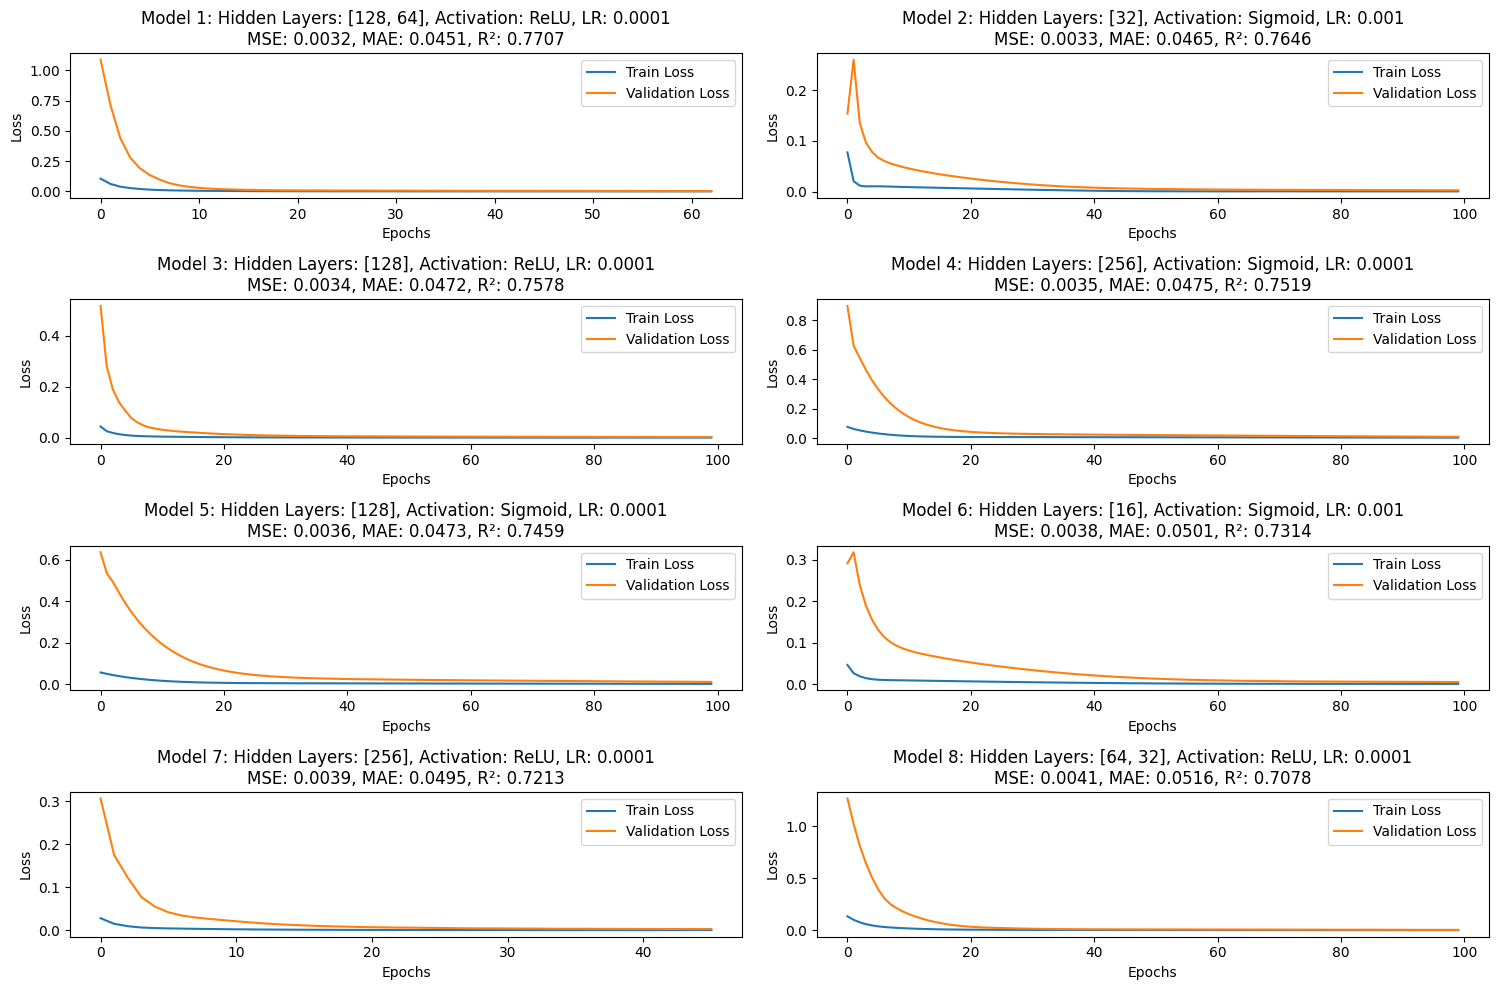

In [751]:
# Ordenar los resultados por MSE
sorted_results = sorted(results_relu_sigmoid, key=lambda x: x['mse'])

# Seleccionar los 8 mejores resultados
top_8_results = sorted_results[:8]

# Graficar las pérdidas de entrenamiento y validación de los 8 mejores modelos
plt.figure(figsize=(15, 10))

for i, result in enumerate(top_8_results):
    plt.subplot(4, 2, i+1)
    plt.plot(result['hist_loss']['train'], label='Train Loss')
    plt.plot(result['hist_loss']['val'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f"Model {i+1}: Hidden Layers: {result['hidden_layers_sizes']}, Activation: {result['activation']}, LR: {result['learning_rate']}\nMSE: {result['mse']:.4f}, MAE: {result['mae']:.4f}, R²: {result['r2']:.4f}")

plt.tight_layout()
plt.show()

Observamos como el mejor modelo es una red con dos capas de tamaños 128 y 64 con una tasa de aprendizaje de 0.0001.

En los modelos donde los datos estan poco correlacionados para fijarnos en si el modelo hace sobrepesecializacion o no, debemos mirar si se observa la clasica forma de U en la perdida de validacion que se produce en modelos sobreajustados al haber divergencia entre el conjunto de entrenamiento y el de validación, sin embargo, como nos encontramos en un problema donde los datos estan altisimiamente correlacionados y encima trabajamos series temporales, debemos usar otra estrategia para evaluar el sobreajuste.

Para hacerlo podemos comparar los MSE que se obtienen con el modelo usando el conjunto de entrenamiento como test y con el modelo de test.

En esta primera ejecucion hemos utilizado 100 epocas y a continuacion mostramos el MSE tanto con el conjunto de entramiento como con el de test con el mejor modelo para ver si hay sobreajuste o no.

#### Mejor modelo con ReLU 100 epocas

  0%|          | 0/100 [00:00<?, ?it/s]

Datos de test: 
MSE: 0.0034, MAE: 0.0471, R²: 0.7563
Datos de entrenamiento: 
MSE: 0.0004, MAE: 0.0155, R²: 0.9927


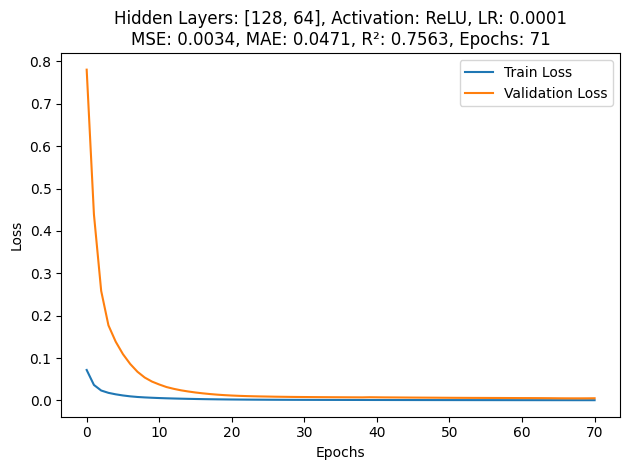

In [834]:
input_size = X_train_scaled.shape[1]

model = MLP(input_size, [128, 64], activation=nn.ReLU)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Entrenar el modelo
hist_loss = train_loop(model, train_loader, val_loader, optimizer, patience=5, epochs=100)

# Evaluar el modelo en el conjunto de test
model.eval()
preds, true = test_model(model, test_loader)
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)
r2 = r2_score(true, preds)

print('Datos de test: ')
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

preds, true = test_model(model, train_loader)
mse_train = mean_squared_error(true, preds)
mae_train = mean_absolute_error(true, preds)
r2_train = r2_score(true, preds)

print('Datos de entrenamiento: ')
print(f'MSE: {mse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}')

plot = plt.plot(hist_loss['train'], label='Train Loss')
plt.plot(hist_loss['val'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f"Hidden Layers: [128, 64], Activation: ReLU, LR: 0.0001\nMSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, Epochs: {len(hist_loss['train'])}")
plt.tight_layout()
plt.show()


Sin embargo, pese a ser el mejor modelo, si observamos la metrica MSE para el mismo modelo con el conjunto de entrenamiento y el de test, vemos que el MSE del conjunto de entrenamiento es 7.5 veces menor que el de test, tambien podemos observar un gran indicador de sobreajuste si miramos la R² dado que en el de test tenemos un 0.78 y en el de entrenamiento tenemos un 0.99.

Por otra parte si miramos el mejor modelo de Sigmoid que corresponde al de 1 capa de 128 neuronas, observamos lo siguiente:

#### Mejor modelo Sigmoid 100 epocas

  0%|          | 0/100 [00:00<?, ?it/s]

Datos de test: 
MSE: 0.0035, MAE: 0.0459, R²: 0.7500
Datos de entrenamiento: 
MSE: 0.0027, MAE: 0.0399, R²: 0.9527


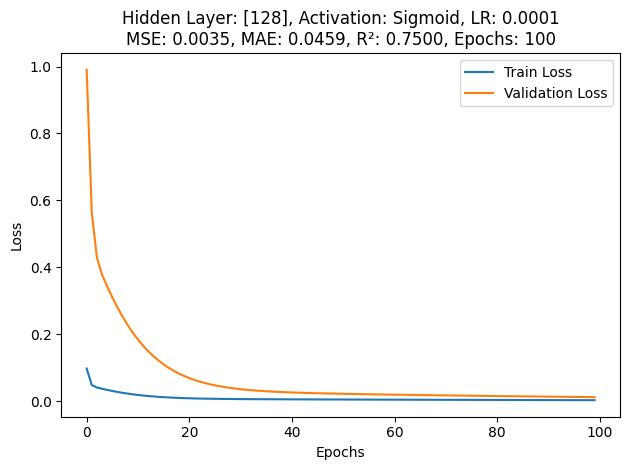

In [857]:
input_size = X_train_scaled.shape[1]

model = MLP(input_size, [128], activation=nn.Sigmoid)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Entrenar el modelo
hist_loss = train_loop(model, train_loader, val_loader, optimizer, patience=5, epochs=100)

# Evaluar el modelo en el conjunto de test
model.eval()
preds, true = test_model(model, test_loader)
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)
r2 = r2_score(true, preds)

print('Datos de test: ')
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

preds, true = test_model(model, train_loader)
mse_train = mean_squared_error(true, preds)
mae_train = mean_absolute_error(true, preds)
r2_train = r2_score(true, preds)

print('Datos de entrenamiento: ')
print(f'MSE: {mse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}')

plot = plt.plot(hist_loss['train'], label='Train Loss')
plt.plot(hist_loss['val'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f"Hidden Layer: [128], Activation: Sigmoid, LR: 0.0001\nMSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, Epochs: {len(hist_loss['train'])}")
plt.tight_layout()
plt.show()

Vemos claramente como este modelo nos gusta un poco mas, las diferencias entre los MSE no son tan exageradas, en este caso solo tenemos un aumento de 1.28 veces por parte del conjunto de entrenamiento y solo perdemos 0.0005 puntos en el valor del MSE.

Vista la gran sobreespecializacion de los datos para la función de ReLU, procederemos a reducir el numero de epocas y para tratar de reducir el sobreajuste en esa funcion de perdida, dado que hemos visto que el mejor modelo para el entrenamiento a la capa 68 por sobreespecialización, asi que reduciremos el numero de epocas a un valor entorno a 20 capas que es cuando observamos que las dos colas empiezan a tener un pendiente muy parecido en los modelos con funcion de perdida ReLU.

##### Reducimos el numero de epocas

In [804]:
# Definir los tamaños de las capas ocultas y las tasas de aprendizaje a explorar
hidden_layer_sizes_list = [[16], [32], [64], [128], [256], [16, 8], [32, 16], [64, 32], [128, 64], [256, 128]]
learning_rates = [10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

# Explorar diferentes configuraciones
results_relu_sigmoid = []
for hidden_layers_sizes in hidden_layer_sizes_list:
    for lr in learning_rates:
        for activation in [nn.Sigmoid, nn.ReLU]:
            hist_loss, mse, mae, r2 = train_and_evaluate(hidden_layers_sizes, activation, lr, epochs=20)
            results_relu_sigmoid.append({
                'hidden_layers_sizes': hidden_layers_sizes,
                'activation': activation.__name__,
                'learning_rate': lr,
                'mse': mse,
                'mae': mae,
                'r2': r2,
                'hist_loss': hist_loss
            })

# Mostrar los resultados
for result in results_relu_sigmoid:
    print(f"Hidden Layers: {result['hidden_layers_sizes']}, Activation: {result['activation']}, Learning Rate: {result['learning_rate']}")
    print(f"MSE: {result['mse']}, MAE: {result['mae']}, R²: {result['r2']}")
    print()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Hidden Layers: [16], Activation: Sigmoid, Learning Rate: 10
MSE: 0.2832748591899872, MAE: 0.5188690423965454, R²: -19.162269592285156

Hidden Layers: [16], Activation: ReLU, Learning Rate: 10
MSE: 0.3201080858707428, MAE: 0.5532253980636597, R²: -21.783899307250977

Hidden Layers: [16], Activation: Sigmoid, Learning Rate: 1
MSE: 0.20426562428474426, MAE: 0.43613743782043457, R²: -13.538737297058105

Hidden Layers: [16], Activation: ReLU, Learning Rate: 1
MSE: 0.2742016911506653, MAE: 0.5100509524345398, R²: -18.516483306884766

Hidden Layers: [16], Activation: Sigmoid, Learning Rate: 0.1
MSE: 0.13390982151031494, MAE: 0.3462080955505371, R²: -8.53111743927002

Hidden Layers: [16], Activation: ReLU, Learning Rate: 0.1
MSE: 0.18598267436027527, MAE: 0.4146479666233063, R²: -12.23743724822998

Hidden Layers: [16], Activation: Sigmoid, Learning Rate: 0.01
MSE: 0.051615383476018906, MAE: 0.1838366538286209, R²: -2.6737582683563232

Hidden Layers: [16], Activation: ReLU, Learning Rate: 0.01


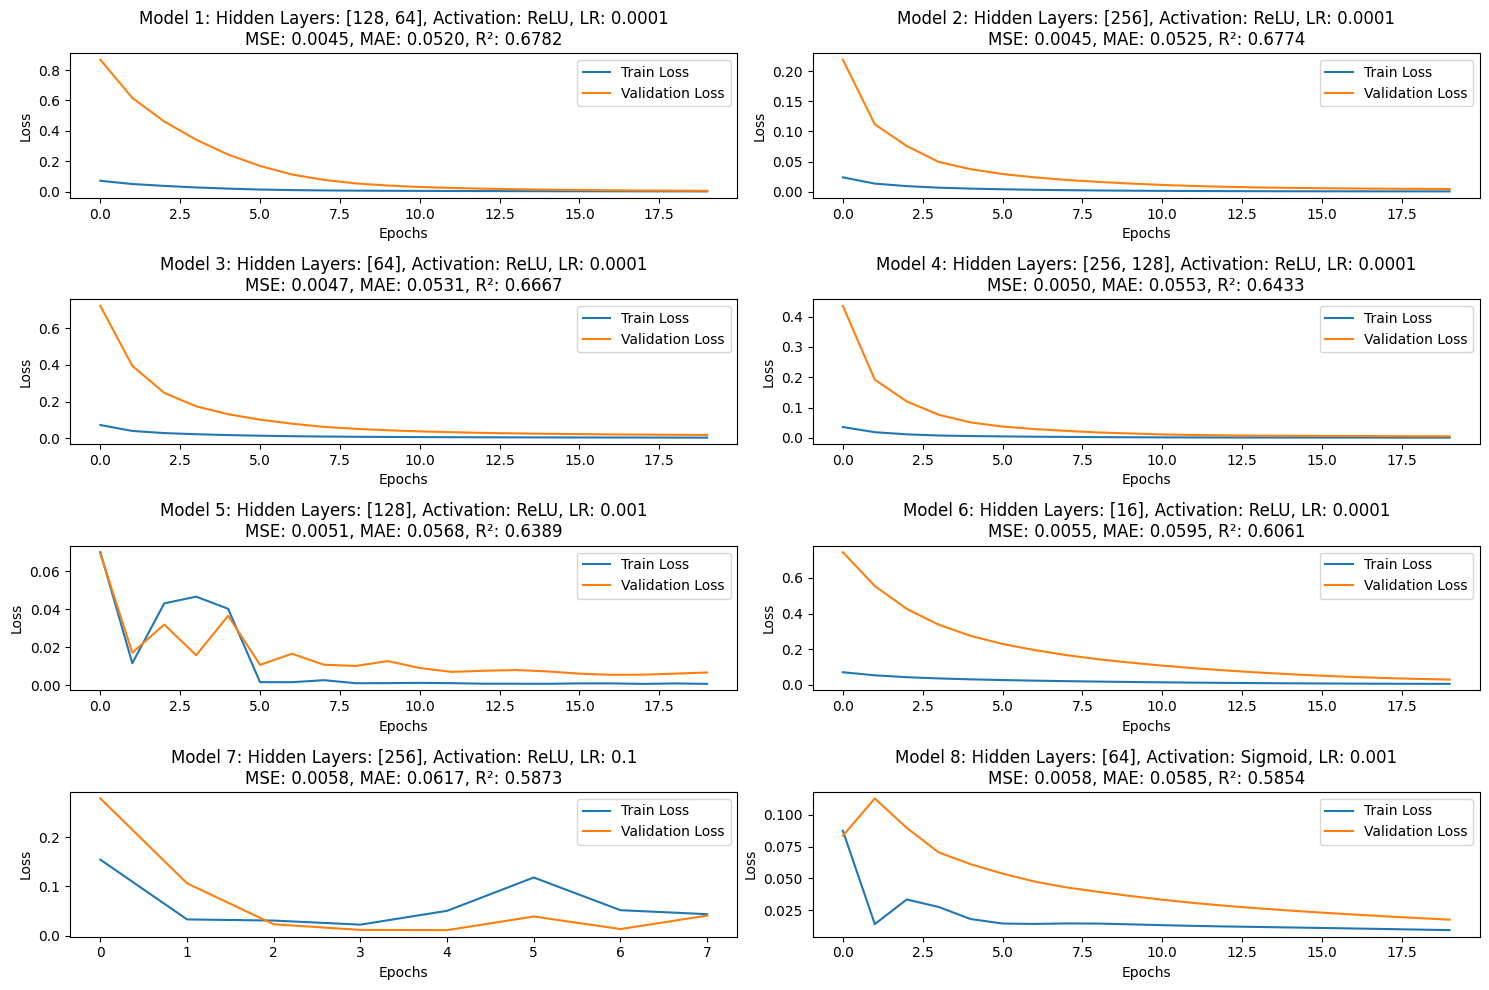

In [805]:
# Ordenar los resultados por MSE
sorted_results = sorted(results_relu_sigmoid, key=lambda x: x['mse'])

# Seleccionar los 8 mejores resultados
top_8_results = sorted_results[:8]

# Graficar las pérdidas de entrenamiento y validación de los 8 mejores modelos
plt.figure(figsize=(15, 10))

for i, result in enumerate(top_8_results):
    plt.subplot(4, 2, i+1)
    plt.plot(result['hist_loss']['train'], label='Train Loss')
    plt.plot(result['hist_loss']['val'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f"Model {i+1}: Hidden Layers: {result['hidden_layers_sizes']}, Activation: {result['activation']}, LR: {result['learning_rate']}\nMSE: {result['mse']:.4f}, MAE: {result['mae']:.4f}, R²: {result['r2']:.4f}")

plt.tight_layout()
plt.show()

#### Mejor modelo ReLU con 20 epocas

  0%|          | 0/20 [00:00<?, ?it/s]

Datos de test: 
MSE: 0.0040, MAE: 0.0501, R²: 0.7171
Datos de entrenamiento: 
MSE: 0.0010, MAE: 0.0249, R²: 0.9819


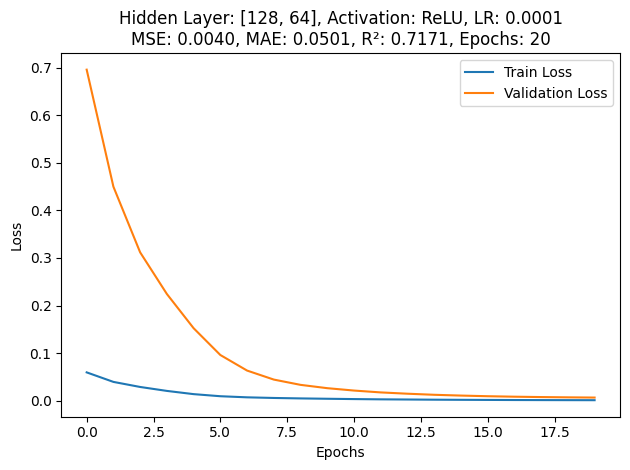

In [845]:
input_size = X_train_scaled.shape[1]

model = MLP(input_size, [128, 64], activation=nn.ReLU)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Entrenar el modelo
hist_loss = train_loop(model, train_loader, val_loader, optimizer, patience=5, epochs=20)

# Evaluar el modelo en el conjunto de test
model.eval()
preds, true = test_model(model, test_loader)
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)
r2 = r2_score(true, preds)

print('Datos de test: ')
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

preds, true = test_model(model, train_loader)
mse_train = mean_squared_error(true, preds)
mae_train = mean_absolute_error(true, preds)
r2_train = r2_score(true, preds)

print('Datos de entrenamiento: ')
print(f'MSE: {mse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}')

plot = plt.plot(hist_loss['train'], label='Train Loss')
plt.plot(hist_loss['val'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f"Hidden Layer: [128, 64], Activation: ReLU, LR: 0.0001\nMSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, Epochs: {len(hist_loss['train'])}")
plt.tight_layout()
plt.show()

Observamos como pese a reducir el numero de epocas a un numero en el que ambas colas ya no son tan planas, seguimos observando como a parte de tener un MSE y una R² mas baja, seguimos teniendo mucha mas sobreespecializacion con la funcion de perdida de ReLU que con el modelo de una red de una capa con 128 neuronas con funcion de perdida Sigmoid, en este caso tenemos un incremento del MSE en el conjunto de entrenamiento de 4 veces.

Por otra parte vemos que con 20 capas no tenemos suficientes para tener un buen modelo con Sigmoid, asi que probaremos con 70 que observando los graficos con las ejecuciones de 100 epocas veiamos que podia ser un numero que se ajustase bien a esa funcion de perdida.

#### Mejor modelo Sigmoid con 70 epocas

  0%|          | 0/70 [00:00<?, ?it/s]

Datos de test: 
MSE: 0.0038, MAE: 0.0470, R²: 0.7268
Datos de entrenamiento: 
MSE: 0.0034, MAE: 0.0446, R²: 0.9403


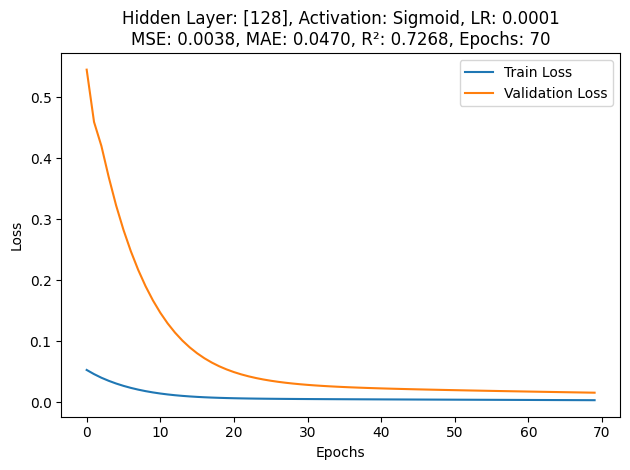

In [869]:
input_size = X_train_scaled.shape[1]

model = MLP(input_size, [128], activation=nn.Sigmoid)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Entrenar el modelo
hist_loss = train_loop(model, train_loader, val_loader, optimizer, patience=5, epochs=70)

# Evaluar el modelo en el conjunto de test
model.eval()
preds, true = test_model(model, test_loader)
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)
r2 = r2_score(true, preds)

print('Datos de test: ')
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

preds, true = test_model(model, train_loader)
mse_train = mean_squared_error(true, preds)
mae_train = mean_absolute_error(true, preds)
r2_train = r2_score(true, preds)

print('Datos de entrenamiento: ')
print(f'MSE: {mse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}')

plot = plt.plot(hist_loss['train'], label='Train Loss')
plt.plot(hist_loss['val'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f"Hidden Layer: [128], Activation: Sigmoid, LR: 0.0001\nMSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, Epochs: {len(hist_loss['train'])}")
plt.tight_layout()
plt.show()


Como vemos finalmente, el modelo Sigmoid es el que mejor nos funciona para los datos, observamos como con 60 capas realizamos un error de 0.0042 en el conjunto de test que es practicamente idéntico al de entrenamiento, solo es 1.1 veces mas grande y por otra parte tenemos un R² que no se nos reduce en exceso 0.73.

Así que podemos concluir este apartado con que el `mejor modelo` es una red de:
- 1 capa
- 128 neuronas
- lr = 0.0001
- funcion de perdida = Sigmoid.
- 70 epocas

### Apartado C

Existen muchas funciones de activación más allá de las clásicas. Experimenta con las funciones de activación LeakyReLU y SiLU con la red con el número de capas que haya tenido mejores resultados explorando el tamaño de las capas. Compara la calidad de los modelos.

1. **SiLU**:
- SiLU(x) = x * Sigmoid(x)
- Tiene una forma parecida a una Sigmoide pero mas parecida a una S. Se usa cuando se quiere una funcion mas sofisticada

2. **LeakyReLU**:

- \begin{cases}
   x & \text{si } x \geq 0, \\
   \alpha x & \text{si } x < 0,
   \end{cases}

- Elimina neuronas "muertas" mediante un hiperparametro


#### Exploración de parámetros
Procedemos ahora a entrenar modelos con 1 capa dado que ha sido el que mejores resultados nos ha dado previamente, explorando tambien el tamaño de la capa y el valor del learning rate, partiremos esta vez con 50 epocas y si es necesario las aumentaremos.

In [854]:
# Definir los tamaños de las capas ocultas y las tasas de aprendizaje a explorar
hidden_layer_sizes_list = [[16], [32], [64], [128], [256]]
learning_rates = [10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

# Explorar diferentes configuraciones
results_leaky_silu = []
for hidden_layers_sizes in hidden_layer_sizes_list:
    for lr in learning_rates:
        for activation in [nn.LeakyReLU, nn.SiLU]:
            hist_loss, mse, mae, r2 = train_and_evaluate(hidden_layers_sizes, activation, lr, epochs=50)
            results_leaky_silu.append({
                'hidden_layers_sizes': hidden_layers_sizes,
                'activation': activation.__name__,
                'learning_rate': lr,
                'mse': mse,
                'mae': mae,
                'r2': r2,
                'hist_loss': hist_loss
            })

# Mostrar los resultados
for result in results_leaky_silu:
    print(f"Hidden Layers: {result['hidden_layers_sizes']}, Activation: {result['activation']}, Learning Rate: {result['learning_rate']}")
    print(f"MSE: {result['mse']}, MAE: {result['mae']}, R²: {result['r2']}")
    print()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Hidden Layers: [16], Activation: LeakyReLU, Learning Rate: 10
MSE: 5026.30078125, MAE: 62.833099365234375, R²: -357749.1875

Hidden Layers: [16], Activation: SiLU, Learning Rate: 10
MSE: 0.22568479180335999, MAE: 0.46003812551498413, R²: -15.063261032104492

Hidden Layers: [16], Activation: LeakyReLU, Learning Rate: 1
MSE: 4.2267045974731445, MAE: 2.040761947631836, R²: -299.83843994140625

Hidden Layers: [16], Activation: SiLU, Learning Rate: 1
MSE: 0.3106819987297058, MAE: 0.544639527797699, R²: -21.112991333007812

Hidden Layers: [16], Activation: LeakyReLU, Learning Rate: 0.1
MSE: 0.1009741723537445, MAE: 0.3062424957752228, R²: -6.186901569366455

Hidden Layers: [16], Activation: SiLU, Learning Rate: 0.1
MSE: 0.17556706070899963, MAE: 0.4018930494785309, R²: -11.496099472045898

Hidden Layers: [16], Activation: LeakyReLU, Learning Rate: 0.01
MSE: 0.013346546329557896, MAE: 0.09201115369796753, R²: 0.05005091428756714

Hidden Layers: [16], Activation: SiLU, Learning Rate: 0.01
MSE:

#### Mejores resultados
Procedemos ahora a mostrar los 8 mejores resultados como hemos hecho previamente

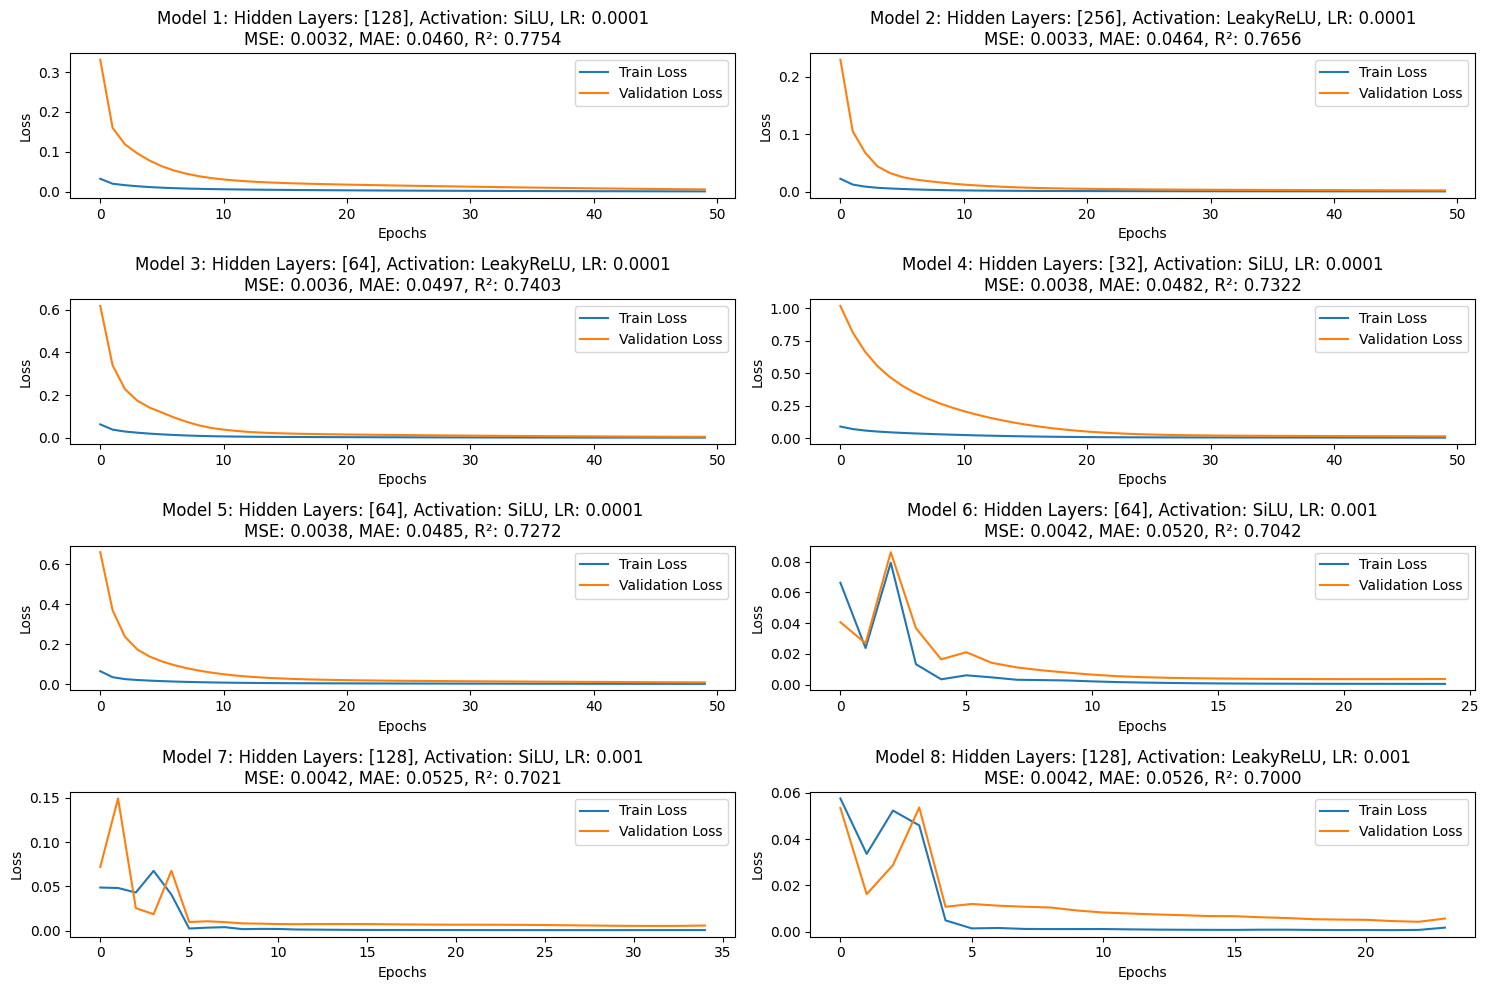

In [870]:
# Ordenar los resultados por MSE
sorted_results = sorted(results_leaky_silu, key=lambda x: x['mse'])

# Seleccionar los 8 mejores resultados
top_8_results = sorted_results[:8]

# Graficar las pérdidas de entrenamiento y validación de los 8 mejores modelos
plt.figure(figsize=(15, 10))

for i, result in enumerate(top_8_results):
    plt.subplot(4, 2, i+1)
    plt.plot(result['hist_loss']['train'], label='Train Loss')
    plt.plot(result['hist_loss']['val'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f"Model {i+1}: Hidden Layers: {result['hidden_layers_sizes']}, Activation: {result['activation']}, LR: {result['learning_rate']}\nMSE: {result['mse']:.4f}, MAE: {result['mae']:.4f}, R²: {result['r2']:.4f}")

plt.tight_layout()
plt.show()

Como podemos observar, no hay un gran cambio que se pueda considerar notorio al cambiar de funcion de perdida si que vemos que ganamos 0.00006 puntos en MSE y nuestra R² aumenta 0.04 puntos respecto el mejor modelo hasta el momento pero no podemos que sea un cambio decisivo, pasaremos ahora a evaluar la sobreespecializacion de estos modelos.

#### Mejor modelo SiLU

  0%|          | 0/50 [00:00<?, ?it/s]

Datos de test: 
MSE: 0.0032, MAE: 0.0453, R²: 0.7739
Datos de entrenamiento: 
MSE: 0.0020, MAE: 0.0336, R²: 0.9642


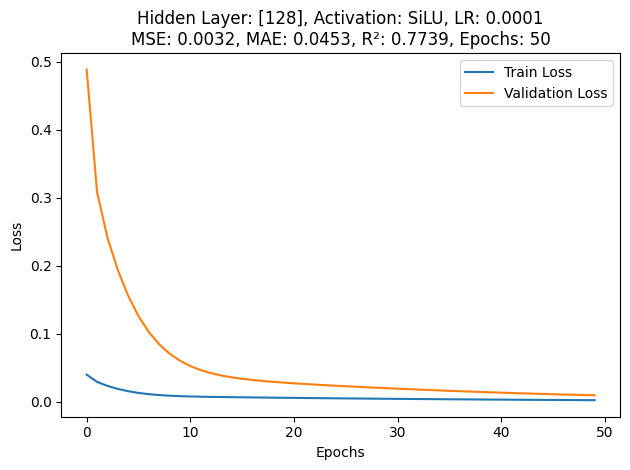

In [912]:
input_size = X_train_scaled.shape[1]

model = MLP(input_size, [128], activation=nn.SiLU)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Entrenar el modelo
hist_loss = train_loop(model, train_loader, val_loader, optimizer, patience=5, epochs=50)

# Evaluar el modelo en el conjunto de test
model.eval()
preds, true = test_model(model, test_loader)
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)
r2 = r2_score(true, preds)

print('Datos de test: ')
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

preds, true = test_model(model, train_loader)
mse_train = mean_squared_error(true, preds)
mae_train = mean_absolute_error(true, preds)
r2_train = r2_score(true, preds)

print('Datos de entrenamiento: ')
print(f'MSE: {mse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}')

plot = plt.plot(hist_loss['train'], label='Train Loss')
plt.plot(hist_loss['val'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f"Hidden Layer: [128], Activation: SiLU, LR: 0.0001\nMSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, Epochs: {len(hist_loss['train'])}")
plt.tight_layout()
plt.show()



Vemos como en el caso de SiLU tenemos un poco mas de sobreespecialiación que en de Sigmoid, tenemos un aumento de mas de 1.5 veces del MSE de test respecto el de entrenamiento pero tenemos una reduccion de 0.0008 puntos en MSE.

Probaremos a continuación con 30 epocas dado que vemos que las dos funciones se aplanan mucho a partir de ese valor.

#### Modelo SiLU con 30 epocas

  0%|          | 0/30 [00:00<?, ?it/s]

Datos de test: 
MSE: 0.0032, MAE: 0.0446, R²: 0.7688
Datos de entrenamiento: 
MSE: 0.0027, MAE: 0.0395, R²: 0.9525


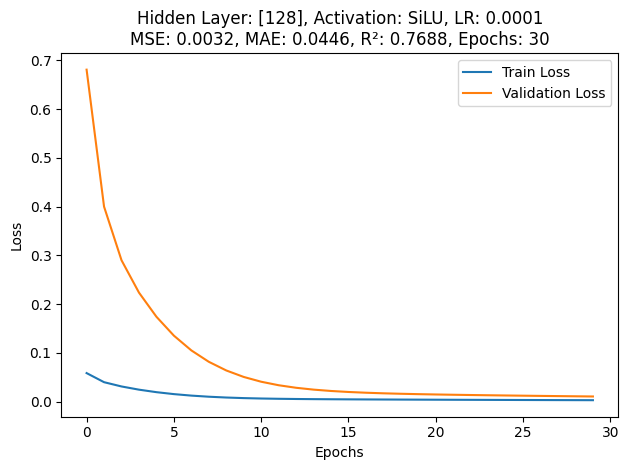

In [1023]:
input_size = X_train_scaled.shape[1]

model = MLP(input_size, [128], activation=nn.SiLU)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Entrenar el modelo
hist_loss = train_loop(model, train_loader, val_loader, optimizer, patience=5, epochs=30)

# Evaluar el modelo en el conjunto de test
model.eval()
preds, true = test_model(model, test_loader)
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)
r2 = r2_score(true, preds)

print('Datos de test: ')
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

preds, true = test_model(model, train_loader)
mse_train = mean_squared_error(true, preds)
mae_train = mean_absolute_error(true, preds)
r2_train = r2_score(true, preds)

print('Datos de entrenamiento: ')
print(f'MSE: {mse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}')

plot = plt.plot(hist_loss['train'], label='Train Loss')
plt.plot(hist_loss['val'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f"Hidden Layer: [128], Activation: SiLU, LR: 0.0001\nMSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, Epochs: {len(hist_loss['train'])}")
plt.tight_layout()
plt.show()



Vemos ahora como este seria el mejor modelo visto hasta el momento dado que solo sufrimos de una sobreespecializacion de 1.2 con MSE y reducimos el MSE del mejor modelo con Sigmoid por 0.0006 puntos.

#### Mejor modelo LeakyReLU
Procedemos de la misma forma con LeakyReLU

  0%|          | 0/50 [00:00<?, ?it/s]

Datos de test: 
MSE: 0.0032, MAE: 0.0461, R²: 0.7710
Datos de entrenamiento: 
MSE: 0.0003, MAE: 0.0143, R²: 0.9941


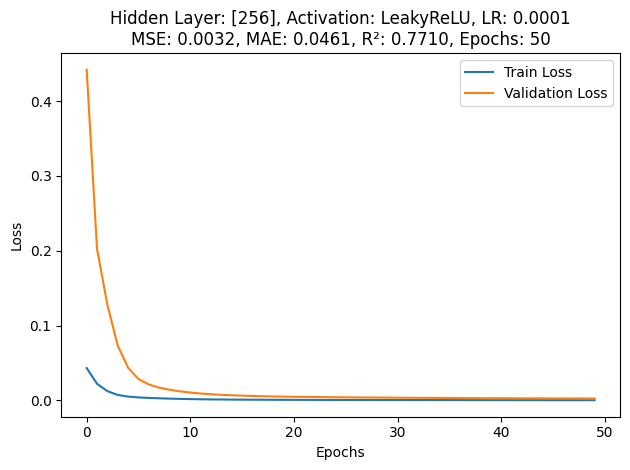

In [890]:
input_size = X_train_scaled.shape[1]

model = MLP(input_size, [256], activation=nn.LeakyReLU)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Entrenar el modelo
hist_loss = train_loop(model, train_loader, val_loader, optimizer, patience=5, epochs=50)

# Evaluar el modelo en el conjunto de test
model.eval()
preds, true = test_model(model, test_loader)
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)
r2 = r2_score(true, preds)

print('Datos de test: ')
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

preds, true = test_model(model, train_loader)
mse_train = mean_squared_error(true, preds)
mae_train = mean_absolute_error(true, preds)
r2_train = r2_score(true, preds)

print('Datos de entrenamiento: ')
print(f'MSE: {mse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}')

plot = plt.plot(hist_loss['train'], label='Train Loss')
plt.plot(hist_loss['val'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f"Hidden Layer: [256], Activation: LeakyReLU, LR: 0.0001\nMSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, Epochs: {len(hist_loss['train'])}")
plt.tight_layout()
plt.show()

Con LeakyReLU vemos que obtenemos unos resultados muy parecidos a si usamos ReLU, tenemos un sobreajuste muy grande.

Podemos probar de reducir el numero de epocas a 20 a ver si obtenemos mehjores resultados que con ReLU.


  0%|          | 0/20 [00:00<?, ?it/s]

Datos de test: 
MSE: 0.0036, MAE: 0.0472, R²: 0.7408
Datos de entrenamiento: 
MSE: 0.0008, MAE: 0.0222, R²: 0.9854


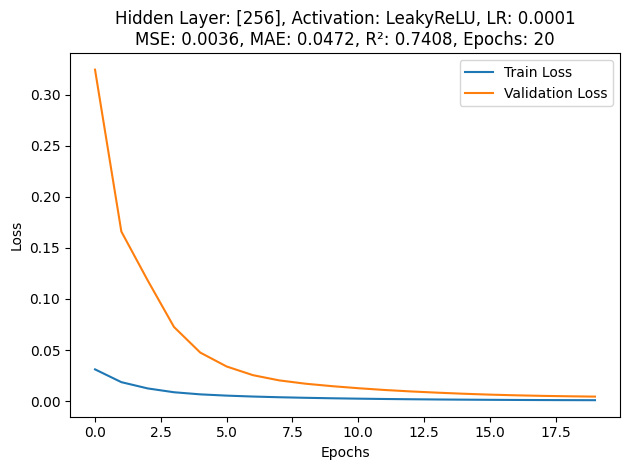

In [899]:
input_size = X_train_scaled.shape[1]

model = MLP(input_size, [256], activation=nn.LeakyReLU)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Entrenar el modelo
hist_loss = train_loop(model, train_loader, val_loader, optimizer, patience=5, epochs=20)

# Evaluar el modelo en el conjunto de test
model.eval()
preds, true = test_model(model, test_loader)
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)
r2 = r2_score(true, preds)

print('Datos de test: ')
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

preds, true = test_model(model, train_loader)
mse_train = mean_squared_error(true, preds)
mae_train = mean_absolute_error(true, preds)
r2_train = r2_score(true, preds)

print('Datos de entrenamiento: ')
print(f'MSE: {mse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}')

plot = plt.plot(hist_loss['train'], label='Train Loss')
plt.plot(hist_loss['val'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f"Hidden Layer: [256], Activation: LeakyReLU, LR: 0.0001\nMSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, Epochs: {len(hist_loss['train'])}")
plt.tight_layout()
plt.show()

Vemos como si reducimos el numero de epocas el incremento de MSE entre entrenamiento y test no es tan grande como con 40 epocas, sin embargo sigue siendo mucho mayor que los de SiLU o Sigmoid.

#### Conclusiones

Observando los resultados obtenidos, vemos que el modelo que nos da unos resultados mejores es el que usa la como función de pérdida SiLU, con 128 ya que es con el que obtenemos un MSE mejor que es la metrica que queremos reducir al entrenar la red a parte de que la R² tambien es obviamente la que nos da un valor mas alto.

`Mejor modelo`:
- 1 capa
- 128 neuronas
- learning rate = 1000
- funcion de perdida = SiLU
- 30 epocas

Pese a ser el mejor modelo, observamos como la R² no es un valor excepcional, se puede considerar decente pero no es perfecto y menos en este problema donde la predicción es muy importante dado que en inversión buscamos siempre minimizar perdidas. Esto podría indicar que el modelo no está capturando completamente toda la complejidad de los datos o simplemente que las variables que tenemos no nos bastan para poder predecir el precio de una acción. (A parte de que hay muchos factores no mesurables, como decisiones políticas, implementación de nuevas leyes/regulaciones... que son muy dificiles de poder quantificar e incluirlas en un modelo de aprendizaje)

Por lo tanto proseguiremos con los siguientes apartados con la expectativa de econtrar un mejor modelo.

### Apartado D

Una cosa que se nos ocurriría es que información sobre la fecha, como el día de la semana, la semana del año, o el mes podrían tener una influencia en las cotizaciones. Verás que el índice del DataFrame de los datos es la fecha. Extrae estos valores y añádeselos a los datos. Ajusta el modelo de red con el número de capas y función de activación que mejor haya funcionado explorando diferentes tamaños en las capas. Compara los resultados.

Procedemos primero a extraer la fecha del indice de los datos y creamos 3 nuevas columnas con el dia de la semana, el mes y el año.

In [959]:
# Extraer características de la fecha y añadirlas al DataFrame

raw_df.index = pd.to_datetime(raw_df.index)
fechas_df = raw_df.index[window_size:]

windowed_df_D = windowed_df.copy()

windowed_df_D['Día'] = fechas_df.dayofweek
windowed_df_D['Año'] = fechas_df.year
windowed_df_D['Mes'] = fechas_df.month

print(windowed_df_D[['Día', 'Año', 'Mes']].head(10))

            Día   Año  Mes
Date                      
2017-08-30    2  2017    8
2017-08-31    3  2017    8
2017-09-01    4  2017    9
2017-09-05    1  2017    9
2017-09-06    2  2017    9
2017-09-07    3  2017    9
2017-09-08    4  2017    9
2017-09-11    0  2017    9
2017-09-12    1  2017    9
2017-09-13    2  2017    9


A continuación repertimos el mismo proceso que antes pero creando nuevas variables para evitar confusiones en posibles reejecuciones.

In [967]:
X_train_D = windowed_df_D.drop(columns=['GOOGLE-P_t7'])[:1000]
X_val_D = windowed_df_D.drop(columns=['GOOGLE-P_t7'])[1000:1100]
X_test_D = windowed_df_D.drop(columns=['GOOGLE-P_t7'])[1100:]

y_train_D = windowed_df_D['GOOGLE-P_t7'][:1000]
y_val_D = windowed_df_D['GOOGLE-P_t7'][1000:1100]
y_test_D = windowed_df_D['GOOGLE-P_t7'][1100:]

In [969]:
# Estandarizar los datos
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled_D = scaler_X.fit_transform(X_train_D)
X_val_scaled_D = scaler_X.transform(X_val_D)
X_test_scaled_D = scaler_X.transform(X_test_D)

y_train_scaled_D = scaler_y.fit_transform(y_train_D.values.reshape(-1, 1))
y_val_scaled_D = scaler_y.transform(y_val_D.values.reshape(-1, 1))
y_test_scaled_D = scaler_y.transform(y_test_D.values.reshape(-1, 1))

# Convertir en arrays de 1D para evitar errores en la futura clase NASDAQ (unsqueeze ya añade una dimension)
y_train_scaled_D = y_train_scaled_D.flatten()
y_val_scaled_D = y_val_scaled_D.flatten()
y_test_scaled_D = y_test_scaled_D.flatten()

# Crear los objetos Dataset
train_dataset_D = NASDAQ(X_train_scaled_D, y_train_scaled_D)
val_dataset_D = NASDAQ(X_val_scaled_D, y_val_scaled_D)
test_dataset_D = NASDAQ(X_test_scaled_D, y_test_scaled_D)

# Crear los objetos DataLoader
batch_size = 32
train_loader_D = DataLoader(train_dataset_D, batch_size=batch_size)
val_loader_D = DataLoader(val_dataset_D, batch_size=batch_size)
test_loader_D = DataLoader(test_dataset_D, batch_size=batch_size)


Verificamos que los datos esten bien escalados y contengan 3 columnas extra (dia, mes, año)

In [970]:
print(X_train_scaled_D.shape)
print(y_train_scaled_D.shape)
print('Valor máximo en X_train_scaled_D:', X_train_scaled_D.max())
print('Valor mínimo en X_train_scaled_D:', X_train_scaled_D.min())

(1000, 108)
(1000,)
Valor máximo en X_train_scaled_D: 1.0000000000000002
Valor mínimo en X_train_scaled_D: 0.0


Procedemos ahora a entrenar los datos nuevos con el mejor 1 capa con funcion perdida SiLU explorando el tamañao de la capa y el valor de la tasa de aprendizaje, para ver si conseguimos unos resultados mejores.

In [1032]:
def train_and_evaluate_D(hidden_layers_sizes, activation, lr, epochs):
    input_size = X_train_scaled_D.shape[1]
    model = MLP(input_size, hidden_layers_sizes, activation=activation)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    hist_loss = train_loop(model, train_loader_D, val_loader_D, optimizer, patience=5, epochs=epochs)
    
    model.eval()
    preds, true = test_model(model, test_loader_D)

    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)
    r2 = r2_score(true, preds)
    
    return hist_loss, mse, mae, r2


hidden_layer_sizes_list = [[16], [32], [64], [128], [256]]
learning_rates = [10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

results_D = []
for hidden_layers_sizes in hidden_layer_sizes_list:
    for lr in learning_rates:
        for activation in [nn.SiLU]:
            hist_loss, mse, mae, r2 = train_and_evaluate_D(hidden_layers_sizes, activation, lr, epochs=30)
            results_D.append({
                'hidden_layers_sizes': hidden_layers_sizes,
                'activation': activation.__name__,
                'learning_rate': lr,
                'mse': mse,
                'mae': mae,
                'r2': r2,
                'hist_loss': hist_loss
            })

# Mostrar los resultados
for result in results_D:
    print(f"Hidden Layers: {result['hidden_layers_sizes']}, Activation: {result['activation']}, Learning Rate: {result['learning_rate']}")
    print(f"MSE: {result['mse']}, MAE: {result['mae']}, R²: {result['r2']}")
    print()

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Hidden Layers: [16], Activation: SiLU, Learning Rate: 10
MSE: 0.32228919863700867, MAE: 0.5551931262016296, R²: -21.93914031982422

Hidden Layers: [16], Activation: SiLU, Learning Rate: 1
MSE: 0.31150397658348083, MAE: 0.5453935861587524, R²: -21.17149543762207

Hidden Layers: [16], Activation: SiLU, Learning Rate: 0.1
MSE: 0.16778621077537537, MAE: 0.3920977711677551, R²: -10.942292213439941

Hidden Layers: [16], Activation: SiLU, Learning Rate: 0.01
MSE: 0.03443663939833641, MAE: 0.17004412412643433, R²: -1.451050043106079

Hidden Layers: [16], Activation: SiLU, Learning Rate: 0.001
MSE: 0.007507040165364742, MAE: 0.07092764228582382, R²: 0.4656815528869629

Hidden Layers: [16], Activation: SiLU, Learning Rate: 0.0001
MSE: 0.014733809977769852, MAE: 0.10393945872783661, R²: -0.048688411712646484

Hidden Layers: [16], Activation: SiLU, Learning Rate: 1e-05
MSE: 0.23220501840114594, MAE: 0.47383996844291687, R²: -15.527341842651367

Hidden Layers: [32], Activation: SiLU, Learning Rate:

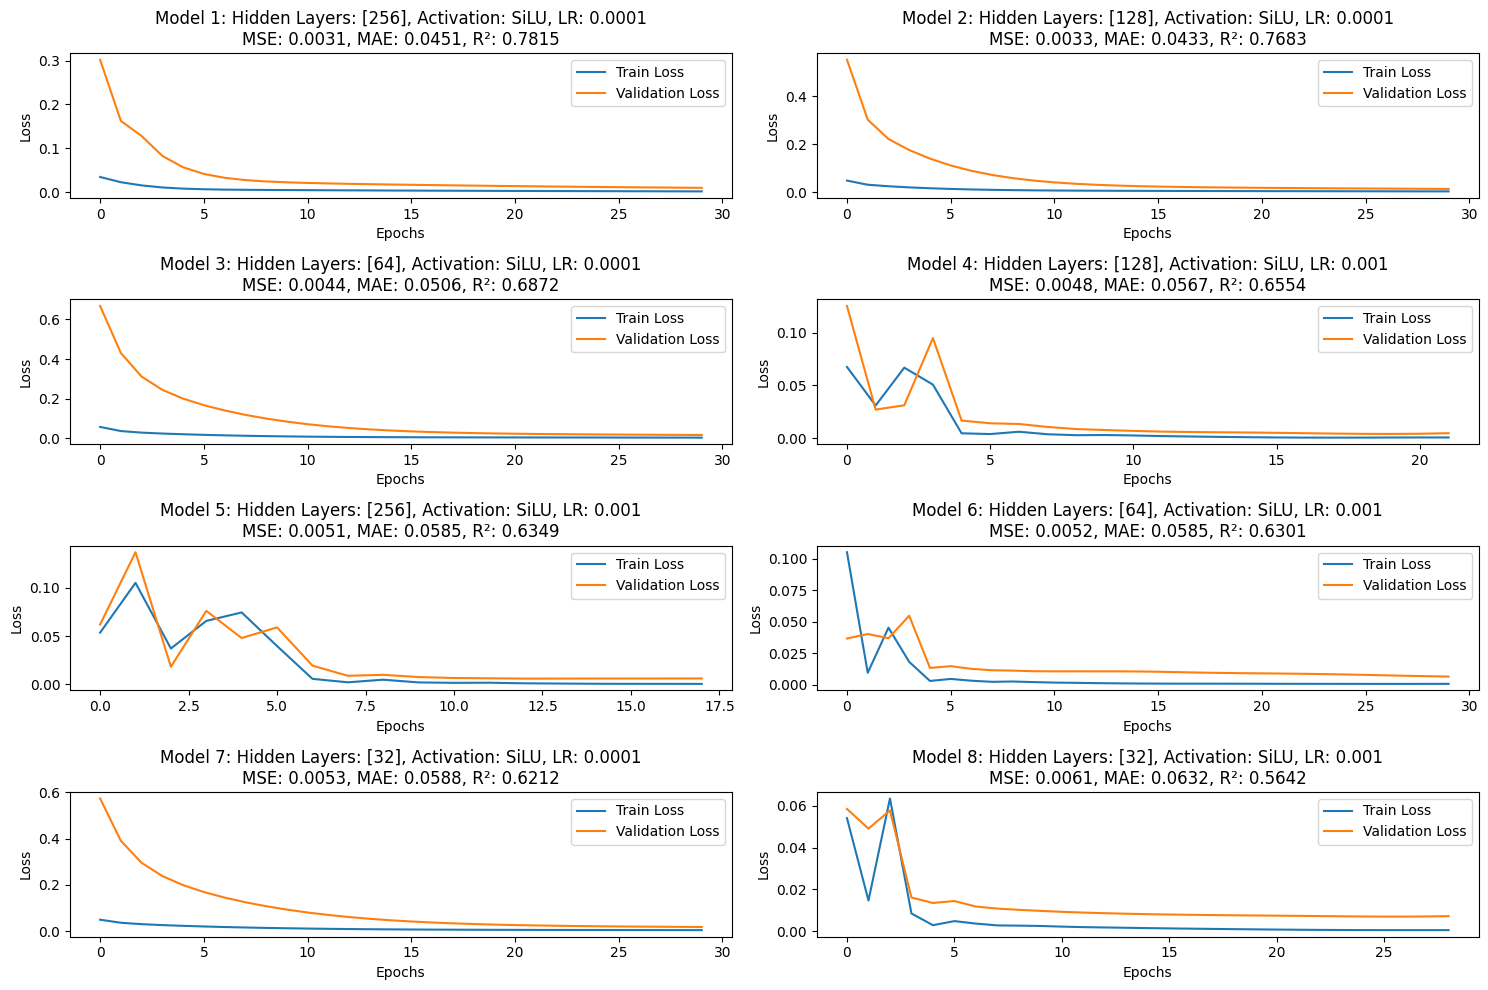

In [1033]:
sorted_results = sorted(results_D, key=lambda x: x['mse'])

top_8_results = sorted_results[:8]

plt.figure(figsize=(15, 10))

for i, result in enumerate(top_8_results):
    plt.subplot(4, 2, i+1)
    plt.plot(result['hist_loss']['train'], label='Train Loss')
    plt.plot(result['hist_loss']['val'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f"Model {i+1}: Hidden Layers: {result['hidden_layers_sizes']}, Activation: {result['activation']}, LR: {result['learning_rate']}\nMSE: {result['mse']:.4f}, MAE: {result['mae']:.4f}, R²: {result['r2']:.4f}")

plt.tight_layout()
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

Datos de test: 
MSE: 0.0031, MAE: 0.0451, R²: 0.7765
Datos de entrenamiento: 
MSE: 0.0025, MAE: 0.0388, R²: 0.9557


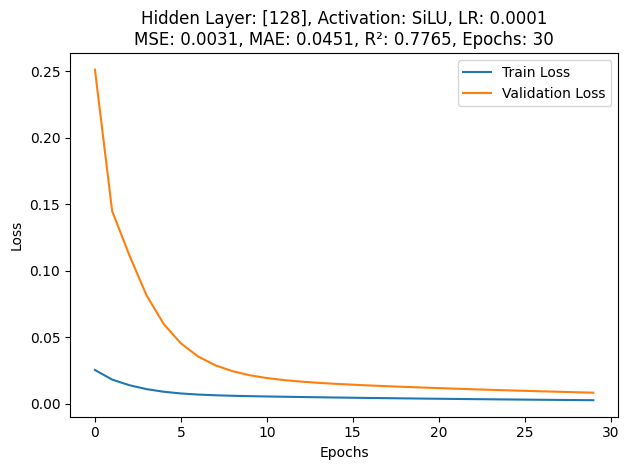

In [1031]:
input_size = X_train_scaled_D.shape[1]

model = MLP(input_size, [128], activation=nn.SiLU)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Entrenar el modelo
hist_loss = train_loop(model, train_loader_D, val_loader_D, optimizer, patience=5, epochs=30)

# Evaluar el modelo en el conjunto de test
model.eval()
preds, true = test_model(model, test_loader_D)
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)
r2 = r2_score(true, preds)

print('Datos de test: ')
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

preds, true = test_model(model, train_loader_D)
mse_train = mean_squared_error(true, preds)
mae_train = mean_absolute_error(true, preds)
r2_train = r2_score(true, preds)

print('Datos de entrenamiento: ')
print(f'MSE: {mse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}')

plot = plt.plot(hist_loss['train'], label='Train Loss')
plt.plot(hist_loss['val'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f"Hidden Layer: [128], Activation: SiLU, LR: 0.0001\nMSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, Epochs: {len(hist_loss['train'])}")
plt.tight_layout()
plt.show()



Finalmente, tras entrenar los modelos para 1 capa con SiLU y 30 epocas dado que era el valor con el que mejor nos había funcionado previamente (que vemos por la forma de la cola de las funciones que sigue siendo el correcto), vemos como el número de neuronas por capa sigue siendo 128, sin embargo, no obtenemos resultados mucho mas significativos, se podrian considerar practicamente iguales (dependiendo de la inicializacion de los valores de las neuronas podria variar un poco).

### Apartado E

Un modelo base que podemos utilizar para saber si realmente estamos prediciendo algo es el llamado modelo de persistencia. Para este problema sería usar el valor de la acción de Google del día anterior como predicción. Calcula el MAE y el MSE para este modelo y compáralo con los resultados que has obtenido con el MLP.

Para aplicar este modelo debemos comparar los datos de test que hemos usado con los mismos datos para el de persistencia

In [936]:
# cojemos todos los valores menos el último
y_pred_persistence = y_test_scaled[:-1]
print('Variable predicha:', y_pred_persistence[:5])

# cojemos todos los valores menos el primero
y_true_persistence = y_test_scaled[1:]
print('Variable real:', y_true_persistence[:5])

# Calcular MAE y MSE para el modelo de persistencia
mae_persistence = mean_absolute_error(y_true_persistence, y_pred_persistence)
mse_persistence = mean_squared_error(y_true_persistence, y_pred_persistence)
r2_persistence = r2_score(y_true_persistence, y_pred_persistence)

print(f'Modelo de Persistencia - MAE: {mae_persistence}, MSE: {mse_persistence}, R²: {r2_persistence}')

Variable predicha: [[1.02133778]
 [0.9945311 ]
 [1.00151234]
 [0.96427906]
 [0.95747887]]
Variable real: [[0.9945311 ]
 [1.00151234]
 [0.96427906]
 [0.95747887]
 [0.93462876]]
Modelo de Persistencia - MAE: 0.024978153760637157, MSE: 0.0009973537112772496, R²: 0.9282706545171904


#### Conclusiones

Finalmente, tras aplicar le modelo de persistencia vemos como realmente se obtienen mejores resultados ya que en el modelo de persistencia obtenemos un MSE de 0.00099 mientras que en el mejor modelo obtenido, el modelo de 1 capa con funcion de perdida SiLU, obteníamos un MSE de 0.0032.

Por lo tanto podemos concluir con que simplemente diciendo que el valor de la acción de mañana será el mismo que el de hoy se obtienen mejores predicciones que usando una red neuronal con series temporales.

Como hemos visto, los resultados obtenidos, cumplen con nuestra hipótesis de que no es viable predecir el valor de una acción con solo datos númericos y/o tabulares, no nos bastan variables númericas y categóricas(aunque en este caso no las hemos usado), para abordar predicciones de este calibre, se necesitan muchísimos factores como hemos ido mencionando previamente, una noticia de ultima hora, puede hacer que el precio de una acción baje estrepitosamente o sin ir mas lejos, cuando una empresa presenta resultados trimestrales, si los resultados estan muy por encima de las espectativas, la acción subirá drásticamente y viceversa si los resultados son peores de los esperados.

